### Heat Alerts theft detection
#### Author : Shweta Gupta
#### Date : 03/27/2020

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandasql import sqldf

#read and store the dataset from csv file
path ='C:\\Users\shwet\Documents\shweta\Winter_2020/Integearte_ALY6080/GE_Data/indicator_data.csv'
ind_data = pd.read_csv(path)
heat_score = pd.read_csv("C:\\Users\shwet\Documents\shweta\Winter_2020/Integearte_ALY6080/GE_Data/heat_scores.csv")
demo_data = pd.read_csv("C:\\Users\shwet\Documents\shweta\Winter_2020/Integearte_ALY6080/GE_Data/obfuscated_demo_data.csv")
demo_data_upd = pd.read_csv("C:\\Users\shwet\Documents\shweta\Winter_2020/Integearte_ALY6080/GE_Data/obfuscated_demo_data2_no_dup.csv")
ind_pair_data =  pd.read_csv("C:\\Users\shwet\Documents\shweta\Winter_2020/Integearte_ALY6080/GE_Data/indicator_pairs_data.csv")
ind_pair_data_upd =  pd.read_csv("C:\\Users\shwet\Documents\shweta\Winter_2020/Integearte_ALY6080/GE_Data/indicator_pairs_data updated.csv")

pysqldf = lambda q: sqldf(q, globals())


# imputing tenure
demo_data_upd['ge_hire_date'] = demo_data_upd['ge_hire_date'].astype('datetime64[ns]') 
demo_data_upd['ge_hire_year']=demo_data_upd['ge_hire_date'].dt.year
from datetime import datetime
demo_data_upd['employee_tenure']=datetime.today().year - demo_data_upd['ge_hire_year']

#imputing missing value
demo_data_upd["country_name"].fillna("No_Data", inplace = True)
demo_data_upd["state_name"].fillna("No_Data", inplace = True)
demo_data_upd["city"].fillna("No_Data", inplace = True)
demo_data_upd["function_group"].fillna("No_Data", inplace = True)



C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#imputing tenure using decison tree
df_new= pd.get_dummies( demo_data_upd, columns = ['job_function','career_band'] )
# print(df_new.head(10))
test = df_new[df_new['employee_tenure'].isnull()== True]
train = df_new[df_new['employee_tenure'].isnull()== False]

x_test = test.iloc[:,11:]
y_test = test.employee_tenure
y = train.employee_tenure
x = train.iloc[:,11:]
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.2)

# train.employee_tenure
from sklearn.tree import DecisionTreeRegressor
clf = DecisionTreeRegressor()

# Train Decision Tree Classifer
clf = clf.fit(x,y)

#Predict the response for test dataset
y_pred = clf.predict(x_test)
# print('Accuarcy score ='+str(accuracy_score(y_test, y_pred)))

test.reset_index(drop=True, inplace=True)
test['Predicted_tenure']=round(pd.DataFrame(y_pred),0)
test

#updating the predicted values
q = """
select  a.*,
(case when a.employee_tenure is null then(select t.Predicted_tenure from test t where t.employee_id = a.employee_id )
     else
     a.employee_tenure
END) employee_tenure_cal
      from demo_data_upd a;
"""
emp_data =pysqldf(q)

emp_data['employee_tenure']=emp_data['employee_tenure_cal']
emp_data=emp_data.drop(columns = ['employee_tenure_cal'])
# emp_data.to_csv('emp_data.csv')

C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [4]:
#filtering only heat alerts
heat_ind_pair_dat = ind_pair_data_upd[ind_pair_data_upd['alert_category']=='Heat']
print(heat_ind_pair_dat.shape[0])

# removind duplicate alert_id and employee_id and keeping the last vaue
heat_ind_pair_dat_no_dup=heat_ind_pair_dat.drop_duplicates(subset=['alert_id_fk','employee_id','alert_type'], keep='last')
# heat_model_data.drop_duplicates(subset=['alert_id_fk','employee_id'],keep='last',inplace=True)

# storing the dataframe to csv
heat_ind_pair_dat_no_dup.to_csv('heat_ind_pair_dat_no_dup.csv')
print(heat_ind_pair_dat_no_dup.shape[0])

39488
38056


In [5]:
# merging employee and indicator_pair
q = """
select  a.*,b.*
      from heat_ind_pair_dat_no_dup a inner join emp_data b
      on a.employee_id = b.employee_id ;
"""
merge_data =pysqldf(q)
display(merge_data.shape[0])

#removing duplicate columns
final_data = merge_data.loc[:,~merge_data.columns.duplicated()]
print('Number of rows after removing duplicates: %s'%final_data.shape[0])

# splitting the indicator pairs to extract indicators
from pandas import Series
s = final_data['indicator_pairs'].str.split('/').apply(Series, 1).stack()
s
s.index = s.index.droplevel(-1)
s.name = 'indicators'
print(s)
# del final_data['indicator_pairs']
model_data = final_data.join(s)

#imputing missing value
model_data["country_name"].fillna("No_Data", inplace = True)
model_data["state_name"].fillna("No_Data", inplace = True)
model_data["city"].fillna("No_Data", inplace = True)
model_data["owner_name"].fillna("No_Data", inplace = True)
model_data["function_group"].fillna("No_Data", inplace = True)

print('Number of rows after model_data: %s'%model_data.shape[0])

38056

Number of rows after removing duplicates: 38056
0        App_1_Heat_Box_PRE_2016_Q3
1        App_1_Heat_Box_PRE_2016_Q3
2        App_1_Heat_Box_PRE_2016_Q3
3        App_1_Heat_Box_PRE_2016_Q3
4        App_1_Heat_Box_PRE_2016_Q3
                    ...            
38054          App_3_Heat_Email_ZIP
38054          App_9_Heat_Email_IND
38054      Threshold_Heat_Email_IND
38055           App_3_Heat_Email_CD
38055      Threshold_Heat_Email_IND
Name: indicators, Length: 113264, dtype: object
Number of rows after model_data: 113264


In [27]:
#Query to fetch duplicate alert_id
q = """
select  alert_id_fk, count(alert_id_fk)
from model_data
where alert_category ='Heat'
group by alert_id_fk
having count(alert_id_fk) > 1;
"""
pysqldf(q)

alert_id_fk  count(alert_id_fk)
0          1854646                   2
1          1854682                   2
2          2782873                   3
3          2782887                   3
4          2802972                   7
...            ...                 ...
31186   2312580134                   6
31187   2312600135                   3
31188   2312610135                   8
31189   2312630136                   3
31190   2312650136                   3

[31191 rows x 2 columns]

In [6]:
#-------------------------------------------------------------------------------------------------------------------------------
#-------------------------------------HEAT ALERTS#------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------------------------
# filtering only atomic records
heat_model_data = model_data[model_data['alert_category']=='Heat']

print('Number of rows in heat_model_data: %s'%heat_model_data.shape[0])

# removing duplicates rows
heat_model_data.drop_duplicates(keep='last',inplace=True)
# # atomic_model_data.to_csv('Atomic_Model_Data.csv')
print('Number of rows after remving duplicates from heat_model_data: %s'%heat_model_data.shape[0])


# # Select duplicate rows except first occurrence based on all columns
# duplicateRowsDF = heat_model_data[heat_model_data.duplicated()]
 
# print("Duplicate Rows except first occurrence based on all columns are :")
# print(duplicateRowsDF)

# heat_model_data.to_csv('heat_model_data.csv')
# duplicateRowsDF.to_csv('duplicateRowsDF.csv')

Number of rows in heat_model_data: 113264
Number of rows after remving duplicates from heat_model_data: 106661


In [7]:
heat_model_final_data = heat_model_data.drop(columns = ['alert_id_fk','indicator_pairs','ge_hire_date','alert_escalation_date','insert_date','city','state_name','ge_hire_year','alert_category'])


In [8]:
# heat_score['HEAT_VALUE'].fillna(int(0),inplace =True)
heat_score = pd.read_csv("C:\\Users\shwet\Documents\shweta\Winter_2020/Integearte_ALY6080/GE_Data/heat_scores.csv")

In [9]:
#merging heat csv with heat_model_final_data
q = """
select  a.*,(case when b.heat_value is null then 0 else b.heat_value end) heat_value
      from heat_model_final_data a inner join heat_score b
      on a.indicators = b.SHARED_INDICATION_NAME ;
"""
heat_model_final_data =pysqldf(q)

In [10]:
# printing the columns
count=0
for col in heat_model_data.columns: 
    count= count+1
    print(col) 
print('column count-'+str(count))

alert_escalation_date
alert_id_fk
insert_date
score
owner_name
employee_id
risk_factor
avg_score
classification
hru
alert_category
alert_type
indicator_pairs
person_type
person_status
ge_hire_date
city
state_name
country_name
function_group
job_function
career_band
industry_focus_name
ge_hire_year
employee_tenure
indicators
column count-26


In [87]:
# heat_cluster_data = heat_model_final_data.drop(columns = ['score','avg_score','risk_factor'])
# daily_heat_cluster= heat_cluster_data[heat_cluster_data['alert_type']=='Daily_Heat']
q = """
select  classification,count(*)
      from heat_model_final_data 
      where alert_type ='Daily_Heat'
      group by classification;
"""
pysqldf(q)

classification  count(*)
0             FP      3796
1          TP/DE     29257
2        TP/HIGH      1285
3         TP/LOW      1657

In [11]:
# droping the unwanted columns and performing one hot encoding on categorical variables
heat_cluster_data = heat_model_final_data.drop(columns = ['score','avg_score','risk_factor','country_name'])
# heat_cluster_data['classification'] = heat_cluster_data['classification'].apply(lambda x: 'TP/HIGH' if x =='TP/HIGH' else 'NON-TP/HIGH')
heat_cluster_data = pd.get_dummies( heat_cluster_data, columns = ['classification','owner_name','function_group',
'hru',
'indicators',
'person_type',
'person_status',
'job_function',
'career_band',
'industry_focus_name'] )
# removing employee_id as it a unique id for each employee
heat_cluster_data = heat_cluster_data.drop(columns=['employee_tenure','employee_id','heat_value'])
daily_heat_cluster= heat_cluster_data[heat_cluster_data['alert_type']=='Daily_Heat']
daily_heat_cluster = daily_heat_cluster.drop(columns = ['alert_type'])
daily_heat_cluster

weekly_heat_cluster= heat_cluster_data[heat_cluster_data['alert_type']=='Weekly_Heat']
weekly_heat_cluster = weekly_heat_cluster.drop(columns = ['alert_type'])
weekly_heat_cluster

monthly_heat_cluster= heat_cluster_data[heat_cluster_data['alert_type']=='Monthly_Heat']
monthly_heat_cluster = monthly_heat_cluster.drop(columns = ['alert_type'])
monthly_heat_cluster

# daily_heat_cluster.to_csv('daily_heat_cluster_tphigh.csv')


classification_FP  classification_TP/DE  classification_TP/HIGH  \
142                     0                     1                       0   
143                     0                     1                       0   
144                     0                     1                       0   
151                     0                     1                       0   
152                     0                     1                       0   
...                   ...                   ...                     ...   
113568                  0                     1                       0   
113569                  0                     1                       0   
113582                  0                     1                       0   
113583                  0                     1                       0   
113584                  0                     1                       0   

        classification_TP/LOW  owner_name_Analyst_1  owner_name_Analyst_2  \
142                         0                     0                     0   
143                         0                     0                     0   
144                         0                     0                     0   
151                         0                     0                     0   
152                         0                     0                     0   
...                       ...                   ...                   ...   
113568                      0                     0                     0   
113569                      0                     0                     0   
113582                      0                     0                     0   
113583                      0                     0                     0   
113584                      0                     0                     0   

        owner_name_Analyst_3  owner_name_Analyst_4  owner_name_Analyst_6  \
142                        0                     0                     0   
143                        0                     0                     0   
144                        0                     0                     0   
151                        0                     0                     0   
152                        0                     0                     0   
...                      ...                   ...                   ...   
113568                     0                     0                     0   
113569                     0                     0                     0   
113582                     0                     0                     1   
113583                     0                     0                     1   
113584                     0                     0                     1   

        owner_name_Analyst_7  ...  industry_focus_name_BUSINESS_SEGMENT_10  \
142                        0  ...                                        0   
143                        0  ...                                        0   
144                        0  ...                                        0   
151                        0  ...                                        0   
152                        0  ...                                        0   
...                      ...  ...                                      ...   
113568                     1  ...                                        0   
113569                     1  ...                                        0   
113582                     0  ...                                        0   
113583                     0  ...                                        0   
113584                     0  ...                                        0   

        industry_focus_name_BUSINESS_SEGMENT_11  \
142                                           0   
143                                           0   
144                                           0   
151                                           0   
152                                           0   
...                       

In [66]:
# # assign the heat value for the the respective indicator instead 1
# for col in heat_cluster_data.columns:
#     if 'indicators' in col:
#         heat_cluster_data[col] = heat_cluster_data[col]*heat_cluster_data['heat_value']

In [53]:
# heat_cluster_data = pd.get_dummies( heat_cluster_data, columns = ['indicators'] )
# dummies = pd.get_dummies(df['Mfr Number'])
# dummies.values[dummies != 0] = df['Quantity']
# heat_cluster_data1 = pd.concat([heat_cluster_data,heat_cluster_data.indicators.str.get_dummies().mul(heat_cluster_data.HEAT_VALUE,0)],axis =1)
# heat_cluster_data.to_csv('heat_cluster_data.csv')

0         True
1         True
2         True
3         True
4         True
          ... 
118657    True
118658    True
118659    True
118660    True
118661    True
Name: HEAT_VALUE, Length: 118662, dtype: bool

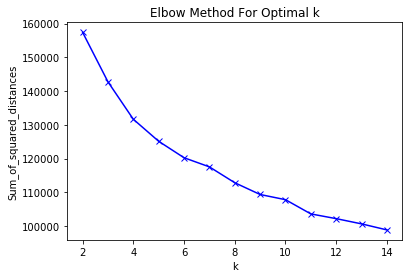

In [85]:
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(2,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(daily_heat_cluster)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [48]:
from sklearn.metrics import silhouette_score

sil = []
kmax = 21

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(daily_heat_cluster)
  labels = kmeans.labels_
  sil.append(silhouette_score(daily_heat_cluster, labels, metric = 'euclidean'))

In [47]:
NumberOfClusters=[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]
plt.plot(NumberOfClusters, sil)
plt.title("Silhouette score values vs Numbers of Clusters ")
plt.ylabel('Silhouette score')
plt.title('Number of Clusters')
plt.show()

# Optimal_NumberOf_Components=NumberOfClusters[silhouette_score_values.index(max(sil))]
# print ('Optimal number of components is:')
# print (Optimal_NumberOf_Components)

In [57]:
#-------------------------------------------------------------------------------------------------------------------------------
# -------------------------------------CLUSTERING : K Means----------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------------------------

#import library
from sklearn.cluster import KMeans

col = 185
# -------Kmeans with  cluster = 4 ----------------------
clut=4
km= KMeans(n_clusters=clut)
kmclusters = km.fit_predict(daily_heat_cluster)

#concatinating the cluster with dataframe
daily_heat_cluster = daily_heat_cluster.reset_index()
daily_heatclustDf = pd.DataFrame(kmclusters)
daily_heatclustDf.columns = ['cluster_predicted']
daily_heatclustDf = pd.concat([daily_heat_cluster, daily_heatclustDf], axis = 1).reset_index()
daily_heatclustDf = daily_heatclustDf.drop(['index', 'level_0'], axis = 1)

# grouping and summing the counts by clusters
grouped = daily_heatclustDf.groupby(['cluster_predicted'], sort=True)
sums = grouped.sum()
sums
# sums.to_csv('final_heat_cluster_k_mean1.csv')
# calculating the mean columnwise for the clusters
for i in range(0,col):
    col_total = sums.iloc[:,i].sum(axis=0)
    for k in range(0,clut):
        sums.iloc[k,i] = round(sums.iloc[k,i]/col_total,2)
sums
saving the output to csv file
sums.to_csv('final_heat_cluster_k_mean1.csv', mode='a', header=True)
# -------Kmeans with  cluster = 5 ----------------------
clut=5
km= KMeans(n_clusters=clut)
kmclusters = km.fit_predict(daily_heat_cluster)

#concatinating the cluster with dataframe
# daily_heatclustDf = daily_heatclustDf.reset_index()
daily_heatclustDf = pd.DataFrame(kmclusters)
daily_heatclustDf.columns = ['cluster_predicted']
daily_heatclustDf = pd.concat([daily_heat_cluster, daily_heatclustDf], axis = 1).reset_index()
daily_heatclustDf = daily_heatclustDf.drop(['index', 'level_0'], axis = 1)
daily_heatclustDf.to_csv('daily_heatclustDf_5.csv')

# grouping and summing the counts by clusters
grouped = daily_heatclustDf.groupby(['cluster_predicted'], sort=True)
sums = grouped.sum()
sums
sums.to_csv('final_heat_cluster_k_mean1.csv', mode='a', header=True)
# calculating the mean columnwise for the clusters
for i in range(0,col):
    col_total = sums.iloc[:,i].sum(axis=0)
    for k in range(0,clut):
        sums.iloc[k,i] = round(sums.iloc[k,i]/col_total,2)
# saving the output to csv file
sums.to_csv('final_heat_cluster_k_mean1.csv', mode='a', header=True)


# -------Kmeans with  cluster = 6 ----------------------
clut=6
km= KMeans(n_clusters=clut)
kmclusters = km.fit_predict(daily_heat_cluster)

#concatinating the cluster with dataframe
# daily_heatclustDf = daily_heatclustDf.reset_index()
daily_heatclustDf = pd.DataFrame(kmclusters)
daily_heatclustDf.columns = ['cluster_predicted']
daily_heatclustDf = pd.concat([daily_heat_cluster, daily_heatclustDf], axis = 1).reset_index()
daily_heatclustDf = daily_heatclustDf.drop(['index', 'level_0'], axis = 1)
daily_heatclustDf.head()

# grouping and summing the counts by clusters
grouped = daily_heatclustDf.groupby(['cluster_predicted'], sort=True)
sums = grouped.sum()
sums
sums.to_csv('final_heat_cluster_k_mean1.csv', mode='a', header=True)
# calculating the mean columnwise for the clusters
for i in range(0,col):
    col_total = sums.iloc[:,i].sum(axis=0)
    for k in range(0,clut):
        sums.iloc[k,i] = round(sums.iloc[k,i]/col_total,2)
# saving the output to csv file
sums.to_csv('final_heat_cluster_k_mean1.csv', mode='a', header=True)


# -------Kmeans with  cluster = 7 ----------------------
clut=7
km= KMeans(n_clusters=clut)
kmclusters = km.fit_predict(daily_heat_cluster)

#concatinating the cluster with dataframe
# daily_heatclustDf = daily_heatclustDf.reset_index()
daily_heatclustDf = pd.DataFrame(kmclusters)
daily_heatclustDf.columns = ['cluster_predicted']
daily_heatclustDf = pd.concat([daily_heat_cluster, daily_heatclustDf], axis = 1).reset_index()
daily_heatclustDf = daily_heatclustDf.drop(['index', 'level_0'], axis = 1)
daily_heatclustDf.head()

# grouping and summing the counts by clusters
grouped = daily_heatclustDf.groupby(['cluster_predicted'], sort=True)
sums = grouped.sum()
sums
sums.to_csv('final_heat_cluster_k_mean1.csv', mode='a', header=True)
# calculating the mean columnwise for the clusters
for i in range(0,col):
    col_total = sums.iloc[:,i].sum(axis=0)
    for k in range(0,clut):
        sums.iloc[k,i] = round(sums.iloc[k,i]/col_total,2)
# saving the output to csv file
sums.to_csv('final_heat_cluster_k_mean1.csv', mode='a', header=True)


# -------Kmeans with  cluster = 8 ----------------------
clut=8
km= KMeans(n_clusters=clut)
kmclusters = km.fit_predict(daily_heat_cluster)

#concatinating the cluster with dataframe
# daily_heatclustDf = daily_heatclustDf.reset_index()
daily_heatclustDf = pd.DataFrame(kmclusters)
daily_heatclustDf.columns = ['cluster_predicted']
daily_heatclustDf = pd.concat([daily_heat_cluster, daily_heatclustDf], axis = 1).reset_index()
daily_heatclustDf = daily_heatclustDf.drop(['index', 'level_0'], axis = 1)
daily_heatclustDf.head()

# grouping and summing the counts by clusters
grouped = daily_heatclustDf.groupby(['cluster_predicted'], sort=True)
sums = grouped.sum()
sums
sums.to_csv('final_heat_cluster_k_mean1.csv', mode='a', header=True)
# calculating the mean columnwise for the clusters
for i in range(0,col):
    col_total = sums.iloc[:,i].sum(axis=0)
    for k in range(0,clut):
        sums.iloc[k,i] = round(sums.iloc[k,i]/col_total,2)
# saving the output to csv file
sums.to_csv('final_heat_cluster_k_mean1.csv', mode='a', header=True)


# -------Kmeans with  cluster = 9 ----------------------
clut=9
km= KMeans(n_clusters=clut)
kmclusters = km.fit_predict(daily_heat_cluster)

#concatinating the cluster with dataframe
# daily_heatclustDf = daily_heatclustDf.reset_index()
daily_heatclustDf = pd.DataFrame(kmclusters)
daily_heatclustDf.columns = ['cluster_predicted']
daily_heatclustDf = pd.concat([daily_heat_cluster, daily_heatclustDf], axis = 1).reset_index()
daily_heatclustDf = daily_heatclustDf.drop(['index', 'level_0'], axis = 1)
daily_heatclustDf.head()

# grouping and summing the counts by clusters
grouped = daily_heatclustDf.groupby(['cluster_predicted'], sort=True)
sums = grouped.sum()
sums
sums.to_csv('final_heat_cluster_k_mean1.csv', mode='a', header=True)
# calculating the mean columnwise for the clusters
for i in range(0,col):
    col_total = sums.iloc[:,i].sum(axis=0)
    for k in range(0,clut):
        sums.iloc[k,i] = round(sums.iloc[k,i]/col_total,2)
# saving the output to csv file
sums.to_csv('final_heat_cluster_k_mean1.csv', mode='a', header=True)


# -------Kmeans with  cluster = 10 ----------------------
clut=10
km= KMeans(n_clusters=clut)
kmclusters = km.fit_predict(daily_heat_cluster)

#concatinating the cluster with dataframe
# daily_heatclustDf = daily_heatclustDf.reset_index()
daily_heatclustDf = pd.DataFrame(kmclusters)
daily_heatclustDf.columns = ['cluster_predicted']
daily_heatclustDf = pd.concat([daily_heat_cluster, daily_heatclustDf], axis = 1).reset_index()
daily_heatclustDf = daily_heatclustDf.drop(['index', 'level_0'], axis = 1)
daily_heatclustDf.head()

# grouping and summing the counts by clusters
grouped = daily_heatclustDf.groupby(['cluster_predicted'], sort=True)
sums = grouped.sum()
sums
sums.to_csv('final_heat_cluster_k_mean1.csv', mode='a', header=True)
# calculating the mean columnwise for the clusters
for i in range(0,col):
    col_total = sums.iloc[:,i].sum(axis=0)
    for k in range(0,clut):
        sums.iloc[k,i] = round(sums.iloc[k,i]/col_total,2)
# saving the output to csv file
sums.to_csv('final_heat_cluster_k_mean1.csv', mode='a', header=True)
# -------Kmeans with  cluster = 11 ----------------------
clut=11
km= KMeans(n_clusters=clut)
kmclusters = km.fit_predict(daily_heat_cluster)

#concatinating the cluster with dataframe
# daily_heatclustDf = daily_heatclustDf.reset_index()
daily_heatclustDf = pd.DataFrame(kmclusters)
daily_heatclustDf.columns = ['cluster_predicted']
daily_heatclustDf = pd.concat([daily_heat_cluster, daily_heatclustDf], axis = 1).reset_index()
daily_heatclustDf = daily_heatclustDf.drop(['index', 'level_0'], axis = 1)
daily_heatclustDf.head()

# grouping and summing the counts by clusters
grouped = daily_heatclustDf.groupby(['cluster_predicted'], sort=True)
sums = grouped.sum()
sums
sums.to_csv('final_heat_cluster_k_mean1.csv', mode='a', header=True)
# calculating the mean columnwise for the clusters
for i in range(0,col):
    col_total = sums.iloc[:,i].sum(axis=0)
    for k in range(0,clut):
        sums.iloc[k,i] = round(sums.iloc[k,i]/col_total,2)
# saving the output to csv file
sums.to_csv('final_heat_cluster_k_mean1.csv', mode='a', header=True)

# -------Kmeans with  cluster = 12 ----------------------
clut=11
km= KMeans(n_clusters=clut)
kmclusters = km.fit_predict(daily_heat_cluster)

#concatinating the cluster with dataframe
# daily_heatclustDf = daily_heatclustDf.reset_index()
daily_heatclustDf = pd.DataFrame(kmclusters)
daily_heatclustDf.columns = ['cluster_predicted']
daily_heatclustDf = pd.concat([daily_heat_cluster, daily_heatclustDf], axis = 1).reset_index()
daily_heatclustDf = daily_heatclustDf.drop(['index', 'level_0'], axis = 1)
daily_heatclustDf.head()

# grouping and summing the counts by clusters
grouped = daily_heatclustDf.groupby(['cluster_predicted'], sort=True)
sums = grouped.sum()
sums
sums.to_csv('final_heat_cluster_k_mean1.csv', mode='a', header=True)
# calculating the mean columnwise for the clusters
for i in range(0,col):
    col_total = sums.iloc[:,i].sum(axis=0)
    for k in range(0,clut):
        sums.iloc[k,i] = round(sums.iloc[k,i]/col_total,2)
# saving the output to csv file
sums.to_csv('final_heat_cluster_k_mean1.csv', mode='a', header=True)

# -------Kmeans with  cluster = 13 ----------------------
clut=13
km= KMeans(n_clusters=clut)
kmclusters = km.fit_predict(daily_heat_cluster)

#concatinating the cluster with dataframe
# daily_heatclustDf = daily_heatclustDf.reset_index()
daily_heatclustDf = pd.DataFrame(kmclusters)
daily_heatclustDf.columns = ['cluster_predicted']
daily_heatclustDf = pd.concat([daily_heat_cluster, daily_heatclustDf], axis = 1).reset_index()
daily_heatclustDf = daily_heatclustDf.drop(['index', 'level_0'], axis = 1)
daily_heatclustDf.head()

# grouping and summing the counts by clusters
grouped = daily_heatclustDf.groupby(['cluster_predicted'], sort=True)
sums = grouped.sum()
sums
sums.to_csv('final_heat_cluster_k_mean1.csv', mode='a', header=True)
# calculating the mean columnwise for the clusters
for i in range(0,col):
    col_total = sums.iloc[:,i].sum(axis=0)
    for k in range(0,clut):
        sums.iloc[k,i] = round(sums.iloc[k,i]/col_total,2)
# saving the output to csv file
sums.to_csv('final_heat_cluster_k_mean1.csv', mode='a', header=True)

# -------Kmeans with  cluster = 14 ----------------------
clut=14
km= KMeans(n_clusters=clut)
kmclusters = km.fit_predict(daily_heat_cluster)

#concatinating the cluster with dataframe
# daily_heatclustDf = daily_heatclustDf.reset_index()
daily_heatclustDf = pd.DataFrame(kmclusters)
daily_heatclustDf.columns = ['cluster_predicted']
daily_heatclustDf = pd.concat([daily_heat_cluster, daily_heatclustDf], axis = 1).reset_index()
daily_heatclustDf = daily_heatclustDf.drop(['index', 'level_0'], axis = 1)
daily_heatclustDf.head()

# grouping and summing the counts by clusters
grouped = daily_heatclustDf.groupby(['cluster_predicted'], sort=True)
sums = grouped.sum()
sums
sums.to_csv('final_heat_cluster_k_mean1.csv', mode='a', header=True)
# calculating the mean columnwise for the clusters
for i in range(0,col):
    col_total = sums.iloc[:,i].sum(axis=0)
    for k in range(0,clut):
        sums.iloc[k,i] = round(sums.iloc[k,i]/col_total,2)
# saving the output to csv file
sums.to_csv('final_heat_cluster_k_mean1.csv', mode='a', header=True)

# -------Kmeans with  cluster = 15 ----------------------
clut=14
km= KMeans(n_clusters=clut)
kmclusters = km.fit_predict(daily_heat_cluster)

#concatinating the cluster with dataframe
# daily_heatclustDf = daily_heatclustDf.reset_index()
daily_heatclustDf = pd.DataFrame(kmclusters)
daily_heatclustDf.columns = ['cluster_predicted']
daily_heatclustDf = pd.concat([daily_heat_cluster, daily_heatclustDf], axis = 1).reset_index()
daily_heatclustDf = daily_heatclustDf.drop(['index', 'level_0'], axis = 1)
daily_heatclustDf.head()

# grouping and summing the counts by clusters
grouped = daily_heatclustDf.groupby(['cluster_predicted'], sort=True)
sums = grouped.sum()
sums
sums.to_csv('final_heat_cluster_k_mean1.csv', mode='a', header=True)
# calculating the mean columnwise for the clusters
for i in range(0,col):
    col_total = sums.iloc[:,i].sum(axis=0)
    for k in range(0,clut):
        sums.iloc[k,i] = round(sums.iloc[k,i]/col_total,2)
# saving the output to csv file
sums.to_csv('final_heat_cluster_k_mean1.csv', mode='a', header=True)

C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars


classification_FP  classification_TP/DE  \
cluster_predicted                                            
0                               0.06                  0.23   
1                               0.77                  0.25   
2                               0.12                  0.39   
3                               0.06                  0.13   

                   classification_TP/HIGH  classification_TP/LOW  \
cluster_predicted                                                  
0                                    0.03                   0.22   
1                                    0.54                   0.37   
2                                    0.37                   0.26   
3                                    0.06                   0.15   

                   owner_name_Analyst_1  owner_name_Analyst_2  \
cluster_predicted                                               
0                                  0.14                   NaN   
1                                  0.26                   NaN   
2                                  0.23                   NaN   
3                                  0.37                   NaN   

                   owner_name_Analyst_3  owner_name_Analyst_4  \
cluster_predicted                                               
0                                   0.0                  0.20   
1                                   1.0                  0.25   
2                                   0.0                  0.25   
3                                   0.0                  0.29   

                   owner_name_Analyst_6  owner_name_Analyst_7  ...  \
cluster_predicted                                              ...   
0                                  0.29                  0.25  ...   
1                                  0.26                  0.23  ...   
2                                  0.41                  0.48  ...   
3                                  0.04                  0.04  ...   

                   indicators_NA_Heat_NA_IND  \
cluster_predicted                              
0                                        NaN   
1                                        NaN   
2                                        NaN   
3                                        NaN   

                   indicators_Threshold_Heat_BA_IND  \
cluster_predicted                                     
0                                              0.13   
1                                              0.47   
2                                              0.30   
3                                              0.09   

                   indicators_Threshold_Heat_Email_IND  \
cluster_predicted                                        
0                                                 0.26   
1                                                 0.06   
2                                                 0.57   
3                                                 0.11   

                   indicators_Threshold_Heat_NTD_EXE_IND  \
cluster_predicted                                          
0                                                   0.17   
1                                                   0.04   
2                                                   0.21   
3                                                   0.58   

                   indicators_Threshold_Heat_NTD_IND  \
cluster_predicted                                      
0                                                0.4   
1                                                0.5   
2                                                0.0   
3                                                0.1   

                   indicators_Threshold_Heat_Print_IND  \
cluster_predicted                                        
0                                                 0.30   
1                                                 0.00   
2                                                 0.11   
3                                                 0.59   

                  

In [74]:
#-------------------------------------------------------------------------------------------------------------------------------
# -------------------------------------CLUSTERING : K Modes----------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------------------------

#import library
from kmodes.kmodes import KModes

col =185
# -------Kmeans with  cluster = 4 ----------------------
clut=4
km= KModes(n_clusters=clut, init='Huang',n_init = 5 , verbose =1)
kmclusters = km.fit_predict(daily_heat_cluster)

#concatinating the cluster with dataframe
daily_heat_cluster = daily_heat_cluster.reset_index()
daily_heatclustDf = pd.DataFrame(kmclusters)
daily_heatclustDf.columns = ['cluster_predicted']
daily_heatclustDf = pd.concat([daily_heat_cluster, daily_heatclustDf], axis = 1).reset_index()
daily_heatclustDf = daily_heatclustDf.drop(['index', 'level_0'], axis = 1)
daily_heatclustDf.head()

# grouping and summing the counts by clusters
grouped = daily_heatclustDf.groupby(['cluster_predicted'], sort=True)
sums = grouped.sum()
sums
sums.to_csv('final_heat_cluster_k_mode1.csv')
# calculating the mean columnwise for the clusters
for i in range(0,col):
    col_total = sums.iloc[:,i].sum(axis=0)
    for k in range(0,clut):
        sums.iloc[k,i] = round(sums.iloc[k,i]/col_total,2)
# saving the output to csv file
sums.to_csv('final_heat_cluster_k_mode1.csv', mode='a', header=True)

# -------Kmeans with  cluster = 5 ----------------------
clut=5
km= KModes(n_clusters=clut, init='Huang',n_init = 5 , verbose =1)
kmclusters = km.fit_predict(daily_heat_cluster)

#concatinating the cluster with dataframe
# daily_heatclustDf = daily_heatclustDf.reset_index()
daily_heatclustDf = pd.DataFrame(kmclusters)
daily_heatclustDf.columns = ['cluster_predicted']
daily_heatclustDf = pd.concat([daily_heat_cluster, daily_heatclustDf], axis = 1).reset_index()
daily_heatclustDf = daily_heatclustDf.drop(['index', 'level_0'], axis = 1)
daily_heatclustDf.head()

# grouping and summing the counts by clusters
grouped = daily_heatclustDf.groupby(['cluster_predicted'], sort=True)
sums = grouped.sum()
sums
sums.to_csv('final_heat_cluster_k_mode1.csv', mode='a', header=True)
# calculating the mean columnwise for the clusters
for i in range(0,col):
    col_total = sums.iloc[:,i].sum(axis=0)
    for k in range(0,clut):
        sums.iloc[k,i] = round(sums.iloc[k,i]/col_total,2)
# saving the output to csv file
sums.to_csv('final_heat_cluster_k_mode1.csv', mode='a', header=True)


# -------Kmeans with  cluster = 6 ----------------------
clut=6
km= KModes(n_clusters=clut, init='Huang',n_init = 5 , verbose =1)
kmclusters = km.fit_predict(daily_heat_cluster)

#concatinating the cluster with dataframe
# daily_heatclustDf = daily_heatclustDf.reset_index()
daily_heatclustDf = pd.DataFrame(kmclusters)
daily_heatclustDf.columns = ['cluster_predicted']
daily_heatclustDf = pd.concat([daily_heat_cluster, daily_heatclustDf], axis = 1).reset_index()
daily_heatclustDf = daily_heatclustDf.drop(['index', 'level_0'], axis = 1)
daily_heatclustDf.head()

# grouping and summing the counts by clusters
grouped = daily_heatclustDf.groupby(['cluster_predicted'], sort=True)
sums = grouped.sum()
sums
sums.to_csv('final_heat_cluster_k_mode1.csv', mode='a', header=True)
# calculating the mean columnwise for the clusters
for i in range(0,col):
    col_total = sums.iloc[:,i].sum(axis=0)
    for k in range(0,clut):
        sums.iloc[k,i] = round(sums.iloc[k,i]/col_total,2)
# saving the output to csv file
sums.to_csv('final_heat_cluster_k_mode1.csv', mode='a', header=True)


# -------Kmeans with  cluster = 7 ----------------------
clut=7
km=KModes(n_clusters=clut, init='Huang',n_init = 5 , verbose =1)
kmclusters = km.fit_predict(daily_heat_cluster)

#concatinating the cluster with dataframe
# daily_heatclustDf = daily_heatclustDf.reset_index()
daily_heatclustDf = pd.DataFrame(kmclusters)
daily_heatclustDf.columns = ['cluster_predicted']
daily_heatclustDf = pd.concat([daily_heat_cluster, daily_heatclustDf], axis = 1).reset_index()
daily_heatclustDf = daily_heatclustDf.drop(['index', 'level_0'], axis = 1)
daily_heatclustDf.head()

# grouping and summing the counts by clusters
grouped = daily_heatclustDf.groupby(['cluster_predicted'], sort=True)
sums = grouped.sum()
sums
sums.to_csv('final_heat_cluster_k_mode1.csv', mode='a', header=True)
# calculating the mean columnwise for the clusters
for i in range(0,col):
    col_total = sums.iloc[:,i].sum(axis=0)
    for k in range(0,clut):
        sums.iloc[k,i] = round(sums.iloc[k,i]/col_total,2)
# saving the output to csv file
sums.to_csv('final_heat_cluster_k_mode1.csv', mode='a', header=True)


# -------Kmeans with  cluster = 8 ----------------------
clut=8
km= KModes(n_clusters=clut, init='Huang',n_init = 5 , verbose =1)
kmclusters = km.fit_predict(daily_heat_cluster)

#concatinating the cluster with dataframe
# daily_heatclustDf = daily_heatclustDf.reset_index()
daily_heatclustDf = pd.DataFrame(kmclusters)
daily_heatclustDf.columns = ['cluster_predicted']
daily_heatclustDf = pd.concat([daily_heat_cluster, daily_heatclustDf], axis = 1).reset_index()
daily_heatclustDf = daily_heatclustDf.drop(['index', 'level_0'], axis = 1)
daily_heatclustDf.head()

# grouping and summing the counts by clusters
grouped = daily_heatclustDf.groupby(['cluster_predicted'], sort=True)
sums = grouped.sum()
sums
sums.to_csv('final_heat_cluster_k_mode1.csv', mode='a', header=True)
# calculating the mean columnwise for the clusters
for i in range(0,col):
    col_total = sums.iloc[:,i].sum(axis=0)
    for k in range(0,clut):
        sums.iloc[k,i] = round(sums.iloc[k,i]/col_total,2)
# saving the output to csv file
sums.to_csv('final_heat_cluster_k_mode1.csv', mode='a', header=True)


# -------Kmeans with  cluster = 9 ----------------------
clut=9
km= KModes(n_clusters=clut, init='Huang',n_init = 5 , verbose =1)
kmclusters = km.fit_predict(daily_heat_cluster)

#concatinating the cluster with dataframe
# daily_heatclustDf = daily_heatclustDf.reset_index()
daily_heatclustDf = pd.DataFrame(kmclusters)
daily_heatclustDf.columns = ['cluster_predicted']
daily_heatclustDf = pd.concat([daily_heat_cluster, daily_heatclustDf], axis = 1).reset_index()
daily_heatclustDf = daily_heatclustDf.drop(['index', 'level_0'], axis = 1)
daily_heatclustDf.head()

# grouping and summing the counts by clusters
grouped = daily_heatclustDf.groupby(['cluster_predicted'], sort=True)
sums = grouped.sum()
sums
sums.to_csv('final_heat_cluster_k_mode1.csv', mode='a', header=True)
# calculating the mean columnwise for the clusters
for i in range(0,col):
    col_total = sums.iloc[:,i].sum(axis=0)
    for k in range(0,clut):
        sums.iloc[k,i] = round(sums.iloc[k,i]/col_total,2)
# saving the output to csv file
sums.to_csv('final_heat_cluster_k_mode1.csv', mode='a', header=True)


# -------Kmeans with  cluster = 10 ----------------------
clut=10
km= KModes(n_clusters=clut, init='Huang',n_init = 5 , verbose =1)
kmclusters = km.fit_predict(daily_heat_cluster)

#concatinating the cluster with dataframe
# daily_heatclustDf = daily_heatclustDf.reset_index()
daily_heatclustDf = pd.DataFrame(kmclusters)
daily_heatclustDf.columns = ['cluster_predicted']
daily_heatclustDf = pd.concat([daily_heat_cluster, daily_heatclustDf], axis = 1).reset_index()
daily_heatclustDf = daily_heatclustDf.drop(['index', 'level_0'], axis = 1)
daily_heatclustDf.head()

# grouping and summing the counts by clusters
grouped = daily_heatclustDf.groupby(['cluster_predicted'], sort=True)
sums = grouped.sum()
sums
sums.to_csv('final_heat_cluster_k_mode1.csv', mode='a', header=True)
# calculating the mean columnwise for the clusters
for i in range(0,col):
    col_total = sums.iloc[:,i].sum(axis=0)
    for k in range(0,clut):
        sums.iloc[k,i] = round(sums.iloc[k,i]/col_total,2)
# saving the output to csv file
sums.to_csv('final_heat_cluster_k_mode1.csv', mode='a', header=True)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 6257, cost: 169778.0
Run 1, iteration: 2/100, moves: 2871, cost: 168299.0
Run 1, iteration: 3/100, moves: 0, cost: 168299.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 12148, cost: 173888.0
Run 2, iteration: 2/100, moves: 3378, cost: 172409.0
Run 2, iteration: 3/100, moves: 0, cost: 172409.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 10040, cost: 195418.0
Run 3, iteration: 2/100, moves: 990, cost: 195418.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 4890, cost: 183790.0
Run 4, iteration: 2/100, moves: 0, cost: 183790.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 7819, cost: 177221.0
Run 5, iteration: 2/100, 

C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 11554, cost: 199944.0
Run 1, iteration: 2/100, moves: 3540, cost: 199168.0
Run 1, iteration: 3/100, moves: 51, cost: 199168.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 4406, cost: 197415.0
Run 2, iteration: 2/100, moves: 1063, cost: 197414.0
Run 2, iteration: 3/100, moves: 0, cost: 197414.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 8648, cost: 224436.0
Run 3, iteration: 2/100, moves: 3604, cost: 220199.0
Run 3, iteration: 3/100, moves: 448, cost: 220198.0
Run 3, iteration: 4/100, moves: 0, cost: 220198.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 8257, cost: 211489.0
Run 4, iteration: 2/100, moves: 3169, cost: 210892.0
Run 4, iteration: 3/100, moves: 363, cost: 210892.0


C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 11403, cost: 231996.0
Run 1, iteration: 2/100, moves: 5069, cost: 229207.0
Run 1, iteration: 3/100, moves: 3057, cost: 229206.0
Run 1, iteration: 4/100, moves: 0, cost: 229206.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 10538, cost: 207406.0
Run 2, iteration: 2/100, moves: 8483, cost: 204656.0
Run 2, iteration: 3/100, moves: 2169, cost: 204655.0
Run 2, iteration: 4/100, moves: 0, cost: 204655.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 9915, cost: 188205.0
Run 3, iteration: 2/100, moves: 2233, cost: 186699.0
Run 3, iteration: 3/100, moves: 222, cost: 186699.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 15517, cost: 203582.0
Run 4, iteration: 2/100, moves: 3120, cost: 2035

C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in double_scalars


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 7110, cost: 203372.0
Run 1, iteration: 2/100, moves: 3543, cost: 199910.0
Run 1, iteration: 3/100, moves: 268, cost: 199910.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 10467, cost: 203335.0
Run 2, iteration: 2/100, moves: 1833, cost: 203334.0
Run 2, iteration: 3/100, moves: 0, cost: 203334.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 9141, cost: 203647.0
Run 3, iteration: 2/100, moves: 1271, cost: 203647.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 10555, cost: 192487.0
Run 4, iteration: 2/100, moves: 1606, cost: 191095.0
Run 4, iteration: 3/100, moves: 316, cost: 191094.0
Run 4, iteration: 4/100, moves: 0, cost: 191094.0
Init: initializing centroids
Init: initializing cl

C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in double_scalars


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 15632, cost: 180905.0
Run 1, iteration: 2/100, moves: 1013, cost: 180902.0
Run 1, iteration: 3/100, moves: 0, cost: 180902.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 9177, cost: 203614.0
Run 2, iteration: 2/100, moves: 1224, cost: 203079.0
Run 2, iteration: 3/100, moves: 212, cost: 203078.0
Run 2, iteration: 4/100, moves: 0, cost: 203078.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 14445, cost: 186568.0
Run 3, iteration: 2/100, moves: 7706, cost: 180566.0
Run 3, iteration: 3/100, moves: 132, cost: 180564.0
Run 3, iteration: 4/100, moves: 0, cost: 180564.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 14476, cost: 183704.0
Run 4, iteration: 2/100, moves: 471, cost: 183702.0


C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:138: RuntimeWarning: invalid value encountered in double_scalars


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 14035, cost: 199708.0
Run 1, iteration: 2/100, moves: 1775, cost: 199708.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 9087, cost: 195093.0
Run 2, iteration: 2/100, moves: 1821, cost: 194662.0
Run 2, iteration: 3/100, moves: 408, cost: 194662.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 12004, cost: 181010.0
Run 3, iteration: 2/100, moves: 376, cost: 181009.0
Run 3, iteration: 3/100, moves: 0, cost: 181009.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 10690, cost: 200381.0
Run 4, iteration: 2/100, moves: 3914, cost: 198452.0
Run 4, iteration: 3/100, moves: 1042, cost: 197837.0
Run 4, iteration: 4/100, moves: 484, cost: 197836.0
Run 4, iteration: 5/100, moves: 0, cost: 197836

C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:165: RuntimeWarning: invalid value encountered in double_scalars


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 12934, cost: 176298.0
Run 1, iteration: 2/100, moves: 3560, cost: 175620.0
Run 1, iteration: 3/100, moves: 416, cost: 175620.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 10250, cost: 191246.0
Run 2, iteration: 2/100, moves: 1584, cost: 191246.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 10625, cost: 190997.0
Run 3, iteration: 2/100, moves: 837, cost: 190995.0
Run 3, iteration: 3/100, moves: 0, cost: 190995.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 8699, cost: 178454.0
Run 4, iteration: 2/100, moves: 2188, cost: 178297.0
Run 4, iteration: 3/100, moves: 201, cost: 178297.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/

C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:192: RuntimeWarning: invalid value encountered in double_scalars


In [189]:

#-------------------------------------------------------------------------------------------------------------------------------
# -------------------------------------CLUSTERING : K Modes----------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------------------------

#import library
from kmodes.kmodes import KModes

col =185
# -------Kmeans with  cluster = 4 ----------------------
clut=4
km= KModes(n_clusters=clut, init='Huang',n_init = 5 , verbose =1)
kmclusters = km.fit_predict(daily_heat_cluster)

#concatinating the cluster with dataframe
daily_heat_cluster = daily_heat_cluster.reset_index()
daily_heatclustDf = pd.DataFrame(kmclusters)
daily_heatclustDf.columns = ['cluster_predicted']
daily_heatclustDf = pd.concat([daily_heat_cluster, daily_heatclustDf], axis = 1).reset_index()
daily_heatclustDf = daily_heatclustDf.drop(['index', 'level_0'], axis = 1)
daily_heatclustDf.head()

# grouping and summing the counts by clusters
grouped = daily_heatclustDf.groupby(['cluster_predicted'], sort=True)
sums = grouped.sum()
sums
sums.to_csv('daily_heat_cluster_k_mode.csv.csv')
# calculating the mean columnwise for the clusters
for i in range(0,col):
    col_total = sums.iloc[:,i].sum(axis=0)
    for k in range(0,clut):
        sums.iloc[k,i] = round(sums.iloc[k,i]/col_total,2)
# saving the output to csv file
sums.to_csv('daily_heat_cluster_k_mode.csv.csv', mode='a', header=True)

# -------Kmeans with  cluster = 5 ----------------------
clut=5
km= KModes(n_clusters=clut, init='Huang',n_init = 5 , verbose =1)
kmclusters = km.fit_predict(daily_heat_cluster)

#concatinating the cluster with dataframe
# daily_heatclustDf = daily_heatclustDf.reset_index()
daily_heatclustDf = pd.DataFrame(kmclusters)
daily_heatclustDf.columns = ['cluster_predicted']
daily_heatclustDf = pd.concat([daily_heat_cluster, daily_heatclustDf], axis = 1).reset_index()
daily_heatclustDf = daily_heatclustDf.drop(['index', 'level_0'], axis = 1)
daily_heatclustDf.head()

# grouping and summing the counts by clusters
grouped = daily_heatclustDf.groupby(['cluster_predicted'], sort=True)
sums = grouped.sum()
sums
sums.to_csv('daily_heat_cluster_k_mode.csv.csv', mode='a', header=True)
# calculating the mean columnwise for the clusters
for i in range(0,col):
    col_total = sums.iloc[:,i].sum(axis=0)
    for k in range(0,clut):
        sums.iloc[k,i] = round(sums.iloc[k,i]/col_total,2)
# saving the output to csv file
sums.to_csv('daily_heat_cluster_k_mode.csv.csv', mode='a', header=True)


# -------Kmeans with  cluster = 6 ----------------------
clut=6
km= KModes(n_clusters=clut, init='Huang',n_init = 5 , verbose =1)
kmclusters = km.fit_predict(daily_heat_cluster)

#concatinating the cluster with dataframe
# daily_heatclustDf = daily_heatclustDf.reset_index()
daily_heatclustDf = pd.DataFrame(kmclusters)
daily_heatclustDf.columns = ['cluster_predicted']
daily_heatclustDf = pd.concat([daily_heat_cluster, daily_heatclustDf], axis = 1).reset_index()
daily_heatclustDf = daily_heatclustDf.drop(['index', 'level_0'], axis = 1)
daily_heatclustDf.head()

# grouping and summing the counts by clusters
grouped = daily_heatclustDf.groupby(['cluster_predicted'], sort=True)
sums = grouped.sum()
sums
sums.to_csv('daily_heat_cluster_k_mode.csv.csv', mode='a', header=True)
# calculating the mean columnwise for the clusters
for i in range(0,col):
    col_total = sums.iloc[:,i].sum(axis=0)
    for k in range(0,clut):
        sums.iloc[k,i] = round(sums.iloc[k,i]/col_total,2)
# saving the output to csv file
sums.to_csv('daily_heat_cluster_k_mode.csv.csv', mode='a', header=True)


# -------Kmeans with  cluster = 7 ----------------------
clut=7
km=KModes(n_clusters=clut, init='Huang',n_init = 5 , verbose =1)
kmclusters = km.fit_predict(daily_heat_cluster)

#concatinating the cluster with dataframe
# daily_heatclustDf = daily_heatclustDf.reset_index()
daily_heatclustDf = pd.DataFrame(kmclusters)
daily_heatclustDf.columns = ['cluster_predicted']
daily_heatclustDf = pd.concat([daily_heat_cluster, daily_heatclustDf], axis = 1).reset_index()
daily_heatclustDf = daily_heatclustDf.drop(['index', 'level_0'], axis = 1)
daily_heatclustDf.head()

# grouping and summing the counts by clusters
grouped = daily_heatclustDf.groupby(['cluster_predicted'], sort=True)
sums = grouped.sum()
sums
sums.to_csv('daily_heat_cluster_k_mode.csv.csv', mode='a', header=True)
# calculating the mean columnwise for the clusters
for i in range(0,col):
    col_total = sums.iloc[:,i].sum(axis=0)
    for k in range(0,clut):
        sums.iloc[k,i] = round(sums.iloc[k,i]/col_total,2)
# saving the output to csv file
sums.to_csv('daily_heat_cluster_k_mode.csv.csv', mode='a', header=True)


# -------Kmeans with  cluster = 8 ----------------------
clut=8
km= KModes(n_clusters=clut, init='Huang',n_init = 5 , verbose =1)
kmclusters = km.fit_predict(daily_heat_cluster)

#concatinating the cluster with dataframe
# daily_heatclustDf = daily_heatclustDf.reset_index()
daily_heatclustDf = pd.DataFrame(kmclusters)
daily_heatclustDf.columns = ['cluster_predicted']
daily_heatclustDf = pd.concat([daily_heat_cluster, daily_heatclustDf], axis = 1).reset_index()
daily_heatclustDf = daily_heatclustDf.drop(['index', 'level_0'], axis = 1)
daily_heatclustDf.head()

# grouping and summing the counts by clusters
grouped = daily_heatclustDf.groupby(['cluster_predicted'], sort=True)
sums = grouped.sum()
sums
sums.to_csv('daily_heat_cluster_k_mode.csv.csv', mode='a', header=True)
# calculating the mean columnwise for the clusters
for i in range(0,col):
    col_total = sums.iloc[:,i].sum(axis=0)
    for k in range(0,clut):
        sums.iloc[k,i] = round(sums.iloc[k,i]/col_total,2)
# saving the output to csv file
sums.to_csv('daily_heat_cluster_k_mode.csv.csv', mode='a', header=True)


# -------Kmeans with  cluster = 9 ----------------------
clut=9
km= KModes(n_clusters=clut, init='Huang',n_init = 5 , verbose =1)
kmclusters = km.fit_predict(daily_heat_cluster)

#concatinating the cluster with dataframe
# daily_heatclustDf = daily_heatclustDf.reset_index()
daily_heatclustDf = pd.DataFrame(kmclusters)
daily_heatclustDf.columns = ['cluster_predicted']
daily_heatclustDf = pd.concat([daily_heat_cluster, daily_heatclustDf], axis = 1).reset_index()
daily_heatclustDf = daily_heatclustDf.drop(['index', 'level_0'], axis = 1)
daily_heatclustDf.head()

# grouping and summing the counts by clusters
grouped = daily_heatclustDf.groupby(['cluster_predicted'], sort=True)
sums = grouped.sum()
sums
sums.to_csv('daily_heat_cluster_k_mode.csv.csv', mode='a', header=True)
# calculating the mean columnwise for the clusters
for i in range(0,col):
    col_total = sums.iloc[:,i].sum(axis=0)
    for k in range(0,clut):
        sums.iloc[k,i] = round(sums.iloc[k,i]/col_total,2)
# saving the output to csv file
sums.to_csv('daily_heat_cluster_k_mode.csv.csv', mode='a', header=True)


# -------Kmeans with  cluster = 10 ----------------------
clut=10
km= KModes(n_clusters=clut, init='Huang',n_init = 5 , verbose =1)
kmclusters = km.fit_predict(daily_heat_cluster)

#concatinating the cluster with dataframe
# daily_heatclustDf = daily_heatclustDf.reset_index()
daily_heatclustDf = pd.DataFrame(kmclusters)
daily_heatclustDf.columns = ['cluster_predicted']
daily_heatclustDf = pd.concat([daily_heat_cluster, daily_heatclustDf], axis = 1).reset_index()
daily_heatclustDf = daily_heatclustDf.drop(['index', 'level_0'], axis = 1)
daily_heatclustDf.head()

# grouping and summing the counts by clusters
grouped = daily_heatclustDf.groupby(['cluster_predicted'], sort=True)
sums = grouped.sum()
sums
sums.to_csv('daily_heat_cluster_k_mode.csv.csv', mode='a', header=True)
# calculating the mean columnwise for the clusters
for i in range(0,col):
    col_total = sums.iloc[:,i].sum(axis=0)
    for k in range(0,clut):
        sums.iloc[k,i] = round(sums.iloc[k,i]/col_total,2)
# saving the output to csv file
sums.to_csv('daily_heat_cluster_k_mode.csv.csv', mode='a', header=True)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 10353, cost: 182362.0
Run 1, iteration: 2/100, moves: 1369, cost: 182362.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 15106, cost: 184648.0
Run 2, iteration: 2/100, moves: 5220, cost: 181893.0
Run 2, iteration: 3/100, moves: 1991, cost: 181893.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 8042, cost: 186490.0
Run 3, iteration: 2/100, moves: 3652, cost: 183993.0
Run 3, iteration: 3/100, moves: 1477, cost: 183993.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 6546, cost: 180119.0
Run 4, iteration: 2/100, moves: 1816, cost: 178736.0
Run 4, iteration: 3/100, moves: 0, cost: 178736.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 

C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 9907, cost: 194594.0
Run 1, iteration: 2/100, moves: 5263, cost: 190929.0
Run 1, iteration: 3/100, moves: 0, cost: 190929.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 8069, cost: 216705.0
Run 2, iteration: 2/100, moves: 619, cost: 216705.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 6752, cost: 211763.0
Run 3, iteration: 2/100, moves: 141, cost: 211763.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 7984, cost: 221149.0
Run 4, iteration: 2/100, moves: 5, cost: 221148.0
Run 4, iteration: 3/100, moves: 0, cost: 221148.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 11050, cost: 213810.0
Run 5, iteration: 2/100, mo

C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 9694, cost: 208728.0
Run 1, iteration: 2/100, moves: 2369, cost: 195880.0
Run 1, iteration: 3/100, moves: 3337, cost: 192884.0
Run 1, iteration: 4/100, moves: 32, cost: 192884.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 9418, cost: 212770.0
Run 2, iteration: 2/100, moves: 744, cost: 212769.0
Run 2, iteration: 3/100, moves: 0, cost: 212769.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 10377, cost: 205656.0
Run 3, iteration: 2/100, moves: 1947, cost: 205656.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 11181, cost: 198598.0
Run 4, iteration: 2/100, moves: 2621, cost: 197410.0
Run 4, iteration: 3/100, moves: 365, cost: 197410.0
Init: initializing centroids
Init: initializing c

C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in double_scalars


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 8673, cost: 186385.0
Run 1, iteration: 2/100, moves: 1300, cost: 186944.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 12406, cost: 188656.0
Run 2, iteration: 2/100, moves: 3858, cost: 187787.0
Run 2, iteration: 3/100, moves: 2610, cost: 185116.0
Run 2, iteration: 4/100, moves: 247, cost: 185114.0
Run 2, iteration: 5/100, moves: 0, cost: 185114.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 9735, cost: 188905.0
Run 3, iteration: 2/100, moves: 712, cost: 188790.0
Run 3, iteration: 3/100, moves: 24, cost: 188790.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 9332, cost: 201884.0
Run 4, iteration: 2/100, moves: 2582, cost: 201884.0
Init: initializing centroids
Init: initializing cl

C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in double_scalars


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 8231, cost: 189104.0
Run 1, iteration: 2/100, moves: 3181, cost: 184105.0
Run 1, iteration: 3/100, moves: 0, cost: 184105.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 13622, cost: 183974.0
Run 2, iteration: 2/100, moves: 4132, cost: 183746.0
Run 2, iteration: 3/100, moves: 256, cost: 183745.0
Run 2, iteration: 4/100, moves: 0, cost: 183745.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 11781, cost: 187052.0
Run 3, iteration: 2/100, moves: 5742, cost: 183489.0
Run 3, iteration: 3/100, moves: 1586, cost: 183488.0
Run 3, iteration: 4/100, moves: 0, cost: 183488.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 13610, cost: 181625.0
Run 4, iteration: 2/100, moves: 774, cost: 181625.0

C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:138: RuntimeWarning: invalid value encountered in double_scalars


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 12961, cost: 192330.0
Run 1, iteration: 2/100, moves: 2264, cost: 191153.0
Run 1, iteration: 3/100, moves: 605, cost: 191153.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 17591, cost: 201397.0
Run 2, iteration: 2/100, moves: 4132, cost: 201114.0
Run 2, iteration: 3/100, moves: 59, cost: 201114.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 9570, cost: 196893.0
Run 3, iteration: 2/100, moves: 945, cost: 196892.0
Run 3, iteration: 3/100, moves: 0, cost: 196892.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 12735, cost: 179024.0
Run 4, iteration: 2/100, moves: 2176, cost: 179023.0
Run 4, iteration: 3/100, moves: 0, cost: 179023.0
Init: initializing centroids
Init: initializing clu

C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:165: RuntimeWarning: invalid value encountered in double_scalars


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 10723, cost: 179258.0
Run 1, iteration: 2/100, moves: 1643, cost: 179255.0
Run 1, iteration: 3/100, moves: 0, cost: 179255.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 8482, cost: 179488.0
Run 2, iteration: 2/100, moves: 1407, cost: 179488.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 11038, cost: 175425.0
Run 3, iteration: 2/100, moves: 2327, cost: 175424.0
Run 3, iteration: 3/100, moves: 0, cost: 175424.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 9778, cost: 192773.0
Run 4, iteration: 2/100, moves: 177, cost: 192773.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 9819, cost: 173776.0
Run 5, iteration: 2/10

C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:192: RuntimeWarning: invalid value encountered in double_scalars


In [190]:
#-------------------------------------------------------------------------------------------------------------------------------
# -------------------------------------CLUSTERING : K Modes----------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------------------------

#import library
from kmodes.kmodes import KModes

col =185
# -------Kmeans with  cluster = 4 ----------------------
clut=4
km= KModes(n_clusters=clut, init='Huang',n_init = 5 , verbose =1)
kmclusters = km.fit_predict(weekly_heat_cluster)

#concatinating the cluster with dataframe
weekly_heat_cluster = weekly_heat_cluster.reset_index()
weekly_heatclustDf = pd.DataFrame(kmclusters)
weekly_heatclustDf.columns = ['cluster_predicted']
weekly_heatclustDf = pd.concat([weekly_heat_cluster, weekly_heatclustDf], axis = 1).reset_index()
weekly_heatclustDf = weekly_heatclustDf.drop(['index', 'level_0'], axis = 1)
weekly_heatclustDf.head()

# grouping and summing the counts by clusters
grouped = weekly_heatclustDf.groupby(['cluster_predicted'], sort=True)
sums = grouped.sum()
sums
sums.to_csv('weekly_heat_cluster_k_mode.csv')
# calculating the mean columnwise for the clusters
for i in range(0,col):
    col_total = sums.iloc[:,i].sum(axis=0)
    for k in range(0,clut):
        sums.iloc[k,i] = round(sums.iloc[k,i]/col_total,2)
# saving the output to csv file
sums.to_csv('weekly_heat_cluster_k_mode.csv', mode='a', header=True)

# -------Kmeans with  cluster = 5 ----------------------
clut=5
km= KModes(n_clusters=clut, init='Huang',n_init = 5 , verbose =1)
kmclusters = km.fit_predict(weekly_heat_cluster)

#concatinating the cluster with dataframe
# weekly_heatclustDf = weekly_heatclustDf.reset_index()
weekly_heatclustDf = pd.DataFrame(kmclusters)
weekly_heatclustDf.columns = ['cluster_predicted']
weekly_heatclustDf = pd.concat([weekly_heat_cluster, weekly_heatclustDf], axis = 1).reset_index()
weekly_heatclustDf = weekly_heatclustDf.drop(['index', 'level_0'], axis = 1)
weekly_heatclustDf.head()

# grouping and summing the counts by clusters
grouped = weekly_heatclustDf.groupby(['cluster_predicted'], sort=True)
sums = grouped.sum()
sums
sums.to_csv('weekly_heat_cluster_k_mode.csv', mode='a', header=True)
# calculating the mean columnwise for the clusters
for i in range(0,col):
    col_total = sums.iloc[:,i].sum(axis=0)
    for k in range(0,clut):
        sums.iloc[k,i] = round(sums.iloc[k,i]/col_total,2)
# saving the output to csv file
sums.to_csv('weekly_heat_cluster_k_mode.csv', mode='a', header=True)


# -------Kmeans with  cluster = 6 ----------------------
clut=6
km= KModes(n_clusters=clut, init='Huang',n_init = 5 , verbose =1)
kmclusters = km.fit_predict(weekly_heat_cluster)

#concatinating the cluster with dataframe
# weekly_heatclustDf = weekly_heatclustDf.reset_index()
weekly_heatclustDf = pd.DataFrame(kmclusters)
weekly_heatclustDf.columns = ['cluster_predicted']
weekly_heatclustDf = pd.concat([weekly_heat_cluster, weekly_heatclustDf], axis = 1).reset_index()
weekly_heatclustDf = weekly_heatclustDf.drop(['index', 'level_0'], axis = 1)
weekly_heatclustDf.head()

# grouping and summing the counts by clusters
grouped = weekly_heatclustDf.groupby(['cluster_predicted'], sort=True)
sums = grouped.sum()
sums
sums.to_csv('weekly_heat_cluster_k_mode.csv', mode='a', header=True)
# calculating the mean columnwise for the clusters
for i in range(0,col):
    col_total = sums.iloc[:,i].sum(axis=0)
    for k in range(0,clut):
        sums.iloc[k,i] = round(sums.iloc[k,i]/col_total,2)
# saving the output to csv file
sums.to_csv('weekly_heat_cluster_k_mode.csv', mode='a', header=True)


# -------Kmeans with  cluster = 7 ----------------------
clut=7
km=KModes(n_clusters=clut, init='Huang',n_init = 5 , verbose =1)
kmclusters = km.fit_predict(weekly_heat_cluster)

#concatinating the cluster with dataframe
# weekly_heatclustDf = weekly_heatclustDf.reset_index()
weekly_heatclustDf = pd.DataFrame(kmclusters)
weekly_heatclustDf.columns = ['cluster_predicted']
weekly_heatclustDf = pd.concat([weekly_heat_cluster, weekly_heatclustDf], axis = 1).reset_index()
weekly_heatclustDf = weekly_heatclustDf.drop(['index', 'level_0'], axis = 1)
weekly_heatclustDf.head()

# grouping and summing the counts by clusters
grouped = weekly_heatclustDf.groupby(['cluster_predicted'], sort=True)
sums = grouped.sum()
sums
sums.to_csv('weekly_heat_cluster_k_mode.csv', mode='a', header=True)
# calculating the mean columnwise for the clusters
for i in range(0,col):
    col_total = sums.iloc[:,i].sum(axis=0)
    for k in range(0,clut):
        sums.iloc[k,i] = round(sums.iloc[k,i]/col_total,2)
# saving the output to csv file
sums.to_csv('weekly_heat_cluster_k_mode.csv', mode='a', header=True)


# -------Kmeans with  cluster = 8 ----------------------
clut=8
km= KModes(n_clusters=clut, init='Huang',n_init = 5 , verbose =1)
kmclusters = km.fit_predict(weekly_heat_cluster)

#concatinating the cluster with dataframe
# weekly_heatclustDf = weekly_heatclustDf.reset_index()
weekly_heatclustDf = pd.DataFrame(kmclusters)
weekly_heatclustDf.columns = ['cluster_predicted']
weekly_heatclustDf = pd.concat([weekly_heat_cluster, weekly_heatclustDf], axis = 1).reset_index()
weekly_heatclustDf = weekly_heatclustDf.drop(['index', 'level_0'], axis = 1)
weekly_heatclustDf.head()

# grouping and summing the counts by clusters
grouped = weekly_heatclustDf.groupby(['cluster_predicted'], sort=True)
sums = grouped.sum()
sums
sums.to_csv('weekly_heat_cluster_k_mode.csv', mode='a', header=True)
# calculating the mean columnwise for the clusters
for i in range(0,col):
    col_total = sums.iloc[:,i].sum(axis=0)
    for k in range(0,clut):
        sums.iloc[k,i] = round(sums.iloc[k,i]/col_total,2)
# saving the output to csv file
sums.to_csv('weekly_heat_cluster_k_mode.csv', mode='a', header=True)


# -------Kmeans with  cluster = 9 ----------------------
clut=9
km= KModes(n_clusters=clut, init='Huang',n_init = 5 , verbose =1)
kmclusters = km.fit_predict(weekly_heat_cluster)

#concatinating the cluster with dataframe
# weekly_heatclustDf = weekly_heatclustDf.reset_index()
weekly_heatclustDf = pd.DataFrame(kmclusters)
weekly_heatclustDf.columns = ['cluster_predicted']
weekly_heatclustDf = pd.concat([weekly_heat_cluster, weekly_heatclustDf], axis = 1).reset_index()
weekly_heatclustDf = weekly_heatclustDf.drop(['index', 'level_0'], axis = 1)
weekly_heatclustDf.head()

# grouping and summing the counts by clusters
grouped = weekly_heatclustDf.groupby(['cluster_predicted'], sort=True)
sums = grouped.sum()
sums
sums.to_csv('weekly_heat_cluster_k_mode.csv', mode='a', header=True)
# calculating the mean columnwise for the clusters
for i in range(0,col):
    col_total = sums.iloc[:,i].sum(axis=0)
    for k in range(0,clut):
        sums.iloc[k,i] = round(sums.iloc[k,i]/col_total,2)
# saving the output to csv file
sums.to_csv('weekly_heat_cluster_k_mode.csv', mode='a', header=True)


# -------Kmeans with  cluster = 10 ----------------------
clut=10
km= KModes(n_clusters=clut, init='Huang',n_init = 5 , verbose =1)
kmclusters = km.fit_predict(weekly_heat_cluster)

#concatinating the cluster with dataframe
# weekly_heatclustDf = weekly_heatclustDf.reset_index()
weekly_heatclustDf = pd.DataFrame(kmclusters)
weekly_heatclustDf.columns = ['cluster_predicted']
weekly_heatclustDf = pd.concat([weekly_heat_cluster, weekly_heatclustDf], axis = 1).reset_index()
weekly_heatclustDf = weekly_heatclustDf.drop(['index', 'level_0'], axis = 1)
weekly_heatclustDf.head()

# grouping and summing the counts by clusters
grouped = weekly_heatclustDf.groupby(['cluster_predicted'], sort=True)
sums = grouped.sum()
sums
sums.to_csv('weekly_heat_cluster_k_mode.csv', mode='a', header=True)
# calculating the mean columnwise for the clusters
for i in range(0,col):
    col_total = sums.iloc[:,i].sum(axis=0)
    for k in range(0,clut):
        sums.iloc[k,i] = round(sums.iloc[k,i]/col_total,2)
# saving the output to csv file
sums.to_csv('weekly_heat_cluster_k_mode.csv', mode='a', header=True)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 8048, cost: 187109.0
Run 1, iteration: 2/100, moves: 917, cost: 187109.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 7214, cost: 164815.0
Run 2, iteration: 2/100, moves: 304, cost: 164815.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 8672, cost: 177390.0
Run 3, iteration: 2/100, moves: 2002, cost: 177202.0
Run 3, iteration: 3/100, moves: 4165, cost: 170380.0
Run 3, iteration: 4/100, moves: 2931, cost: 170380.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 10797, cost: 172531.0
Run 4, iteration: 2/100, moves: 6289, cost: 164036.0
Run 4, iteration: 3/100, moves: 204, cost: 164036.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1

C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 12815, cost: 193011.0
Run 1, iteration: 2/100, moves: 5412, cost: 190923.0
Run 1, iteration: 3/100, moves: 16, cost: 190923.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 12300, cost: 206383.0
Run 2, iteration: 2/100, moves: 147, cost: 206382.0
Run 2, iteration: 3/100, moves: 0, cost: 206382.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 5937, cost: 202911.0
Run 3, iteration: 2/100, moves: 8257, cost: 196696.0
Run 3, iteration: 3/100, moves: 6331, cost: 195929.0
Run 3, iteration: 4/100, moves: 26, cost: 195928.0
Run 3, iteration: 5/100, moves: 0, cost: 195928.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 11229, cost: 205197.0
Run 4, iteration: 2/100, moves: 7134, cost: 204035.0

C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 9306, cost: 215352.0
Run 1, iteration: 2/100, moves: 0, cost: 215352.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 11984, cost: 187827.0
Run 2, iteration: 2/100, moves: 4462, cost: 186253.0
Run 2, iteration: 3/100, moves: 134, cost: 186252.0
Run 2, iteration: 4/100, moves: 0, cost: 186252.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 13491, cost: 189069.0
Run 3, iteration: 2/100, moves: 4969, cost: 184879.0
Run 3, iteration: 3/100, moves: 1477, cost: 184334.0
Run 3, iteration: 4/100, moves: 0, cost: 184334.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 11404, cost: 197319.0
Run 4, iteration: 2/100, moves: 5901, cost: 193185.0
Run 4, iteration: 3/100, moves: 2885, cost: 184753.

C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in double_scalars


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 9787, cost: 195627.0
Run 1, iteration: 2/100, moves: 864, cost: 195626.0
Run 1, iteration: 3/100, moves: 0, cost: 195626.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 6159, cost: 185336.0
Run 2, iteration: 2/100, moves: 414, cost: 185336.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 10941, cost: 190829.0
Run 3, iteration: 2/100, moves: 4349, cost: 188046.0
Run 3, iteration: 3/100, moves: 1254, cost: 187752.0
Run 3, iteration: 4/100, moves: 0, cost: 187752.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 14386, cost: 192219.0
Run 4, iteration: 2/100, moves: 5959, cost: 180230.0
Run 4, iteration: 3/100, moves: 1140, cost: 180229.0
Run 4, iteration: 4/100, moves: 0, cost: 180229.0


C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in double_scalars


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 15109, cost: 171550.0
Run 1, iteration: 2/100, moves: 8486, cost: 167981.0
Run 1, iteration: 3/100, moves: 14, cost: 167980.0
Run 1, iteration: 4/100, moves: 0, cost: 167980.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 8669, cost: 185292.0
Run 2, iteration: 2/100, moves: 2274, cost: 182967.0
Run 2, iteration: 3/100, moves: 281, cost: 182966.0
Run 2, iteration: 4/100, moves: 0, cost: 182966.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 8138, cost: 207366.0
Run 3, iteration: 2/100, moves: 321, cost: 207365.0
Run 3, iteration: 3/100, moves: 0, cost: 207365.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 9651, cost: 198367.0
Run 4, iteration: 2/100, moves: 1551, cost: 197618.0
Run

C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:138: RuntimeWarning: invalid value encountered in double_scalars


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 8863, cost: 179572.0
Run 1, iteration: 2/100, moves: 38, cost: 179571.0
Run 1, iteration: 3/100, moves: 0, cost: 179571.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 10077, cost: 183322.0
Run 2, iteration: 2/100, moves: 1499, cost: 183319.0
Run 2, iteration: 3/100, moves: 0, cost: 183319.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 13214, cost: 182432.0
Run 3, iteration: 2/100, moves: 6446, cost: 178117.0
Run 3, iteration: 3/100, moves: 1409, cost: 178117.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 13520, cost: 175594.0
Run 4, iteration: 2/100, moves: 1365, cost: 170591.0
Run 4, iteration: 3/100, moves: 1597, cost: 169678.0
Run 4, iteration: 4/100, moves: 416, cost: 169046

C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:165: RuntimeWarning: invalid value encountered in double_scalars


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 9275, cost: 180057.0
Run 1, iteration: 2/100, moves: 3330, cost: 175240.0
Run 1, iteration: 3/100, moves: 2705, cost: 175239.0
Run 1, iteration: 4/100, moves: 0, cost: 175239.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 16980, cost: 183747.0
Run 2, iteration: 2/100, moves: 4867, cost: 181128.0
Run 2, iteration: 3/100, moves: 626, cost: 181128.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 8724, cost: 177535.0
Run 3, iteration: 2/100, moves: 765, cost: 177533.0
Run 3, iteration: 3/100, moves: 0, cost: 177533.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 15666, cost: 192316.0
Run 4, iteration: 2/100, moves: 10932, cost: 179423.0
Run 4, iteration: 3/100, moves: 1136, cost: 17942

C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:192: RuntimeWarning: invalid value encountered in double_scalars


In [191]:
#-------------------------------------------------------------------------------------------------------------------------------
# -------------------------------------CLUSTERING : K Modes for Monthly----------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------------------------

#import library
from kmodes.kmodes import KModes

col =185
# -------Kmeans with  cluster = 4 ----------------------
clut=4
km= KModes(n_clusters=clut, init='Huang',n_init = 5 , verbose =1)
kmclusters = km.fit_predict(monthly_heat_cluster)

#concatinating the cluster with dataframe
monthly_heat_cluster = monthly_heat_cluster.reset_index()
monthly_heatclustDf = pd.DataFrame(kmclusters)
monthly_heatclustDf.columns = ['cluster_predicted']
monthly_heatclustDf = pd.concat([monthly_heat_cluster, monthly_heatclustDf], axis = 1).reset_index()
monthly_heatclustDf = monthly_heatclustDf.drop(['index', 'level_0'], axis = 1)
monthly_heatclustDf.head()

# grouping and summing the counts by clusters
grouped = monthly_heatclustDf.groupby(['cluster_predicted'], sort=True)
sums = grouped.sum()
sums
sums.to_csv('monthly_heat_cluster_k_mode.csv')
# calculating the mean columnwise for the clusters
for i in range(0,col):
    col_total = sums.iloc[:,i].sum(axis=0)
    for k in range(0,clut):
        sums.iloc[k,i] = round(sums.iloc[k,i]/col_total,2)
# saving the output to csv file
sums.to_csv('monthly_heat_cluster_k_mode.csv', mode='a', header=True)

# -------Kmeans with  cluster = 5 ----------------------
clut=5
km= KModes(n_clusters=clut, init='Huang',n_init = 5 , verbose =1)
kmclusters = km.fit_predict(monthly_heat_cluster)

#concatinating the cluster with dataframe
# monthly_heatclustDf = monthly_heatclustDf.reset_index()
monthly_heatclustDf = pd.DataFrame(kmclusters)
monthly_heatclustDf.columns = ['cluster_predicted']
monthly_heatclustDf = pd.concat([monthly_heat_cluster, monthly_heatclustDf], axis = 1).reset_index()
monthly_heatclustDf = monthly_heatclustDf.drop(['index', 'level_0'], axis = 1)
monthly_heatclustDf.head()

# grouping and summing the counts by clusters
grouped = monthly_heatclustDf.groupby(['cluster_predicted'], sort=True)
sums = grouped.sum()
sums
sums.to_csv('monthly_heat_cluster_k_mode.csv', mode='a', header=True)
# calculating the mean columnwise for the clusters
for i in range(0,col):
    col_total = sums.iloc[:,i].sum(axis=0)
    for k in range(0,clut):
        sums.iloc[k,i] = round(sums.iloc[k,i]/col_total,2)
# saving the output to csv file
sums.to_csv('monthly_heat_cluster_k_mode.csv', mode='a', header=True)


# -------Kmeans with  cluster = 6 ----------------------
clut=6
km= KModes(n_clusters=clut, init='Huang',n_init = 5 , verbose =1)
kmclusters = km.fit_predict(monthly_heat_cluster)

#concatinating the cluster with dataframe
# monthly_heatclustDf = monthly_heatclustDf.reset_index()
monthly_heatclustDf = pd.DataFrame(kmclusters)
monthly_heatclustDf.columns = ['cluster_predicted']
monthly_heatclustDf = pd.concat([monthly_heat_cluster, monthly_heatclustDf], axis = 1).reset_index()
monthly_heatclustDf = monthly_heatclustDf.drop(['index', 'level_0'], axis = 1)
monthly_heatclustDf.head()

# grouping and summing the counts by clusters
grouped = monthly_heatclustDf.groupby(['cluster_predicted'], sort=True)
sums = grouped.sum()
sums
sums.to_csv('monthly_heat_cluster_k_mode.csv', mode='a', header=True)
# calculating the mean columnwise for the clusters
for i in range(0,col):
    col_total = sums.iloc[:,i].sum(axis=0)
    for k in range(0,clut):
        sums.iloc[k,i] = round(sums.iloc[k,i]/col_total,2)
# saving the output to csv file
sums.to_csv('monthly_heat_cluster_k_mode.csv', mode='a', header=True)


# -------Kmeans with  cluster = 7 ----------------------
clut=7
km=KModes(n_clusters=clut, init='Huang',n_init = 5 , verbose =1)
kmclusters = km.fit_predict(monthly_heat_cluster)

#concatinating the cluster with dataframe
# monthly_heatclustDf = monthly_heatclustDf.reset_index()
monthly_heatclustDf = pd.DataFrame(kmclusters)
monthly_heatclustDf.columns = ['cluster_predicted']
monthly_heatclustDf = pd.concat([monthly_heat_cluster, monthly_heatclustDf], axis = 1).reset_index()
monthly_heatclustDf = monthly_heatclustDf.drop(['index', 'level_0'], axis = 1)
monthly_heatclustDf.head()

# grouping and summing the counts by clusters
grouped = monthly_heatclustDf.groupby(['cluster_predicted'], sort=True)
sums = grouped.sum()
sums
sums.to_csv('monthly_heat_cluster_k_mode.csv', mode='a', header=True)
# calculating the mean columnwise for the clusters
for i in range(0,col):
    col_total = sums.iloc[:,i].sum(axis=0)
    for k in range(0,clut):
        sums.iloc[k,i] = round(sums.iloc[k,i]/col_total,2)
# saving the output to csv file
sums.to_csv('monthly_heat_cluster_k_mode.csv', mode='a', header=True)


# -------Kmeans with  cluster = 8 ----------------------
clut=8
km= KModes(n_clusters=clut, init='Huang',n_init = 5 , verbose =1)
kmclusters = km.fit_predict(monthly_heat_cluster)

#concatinating the cluster with dataframe
# monthly_heatclustDf = monthly_heatclustDf.reset_index()
monthly_heatclustDf = pd.DataFrame(kmclusters)
monthly_heatclustDf.columns = ['cluster_predicted']
monthly_heatclustDf = pd.concat([monthly_heat_cluster, monthly_heatclustDf], axis = 1).reset_index()
monthly_heatclustDf = monthly_heatclustDf.drop(['index', 'level_0'], axis = 1)
monthly_heatclustDf.head()

# grouping and summing the counts by clusters
grouped = monthly_heatclustDf.groupby(['cluster_predicted'], sort=True)
sums = grouped.sum()
sums
sums.to_csv('monthly_heat_cluster_k_mode.csv', mode='a', header=True)
# calculating the mean columnwise for the clusters
for i in range(0,col):
    col_total = sums.iloc[:,i].sum(axis=0)
    for k in range(0,clut):
        sums.iloc[k,i] = round(sums.iloc[k,i]/col_total,2)
# saving the output to csv file
sums.to_csv('monthly_heat_cluster_k_mode.csv', mode='a', header=True)


# -------Kmeans with  cluster = 9 ----------------------
clut=9
km= KModes(n_clusters=clut, init='Huang',n_init = 5 , verbose =1)
kmclusters = km.fit_predict(monthly_heat_cluster)

#concatinating the cluster with dataframe
# monthly_heatclustDf = monthly_heatclustDf.reset_index()
monthly_heatclustDf = pd.DataFrame(kmclusters)
monthly_heatclustDf.columns = ['cluster_predicted']
monthly_heatclustDf = pd.concat([monthly_heat_cluster, monthly_heatclustDf], axis = 1).reset_index()
monthly_heatclustDf = monthly_heatclustDf.drop(['index', 'level_0'], axis = 1)
monthly_heatclustDf.head()

# grouping and summing the counts by clusters
grouped = monthly_heatclustDf.groupby(['cluster_predicted'], sort=True)
sums = grouped.sum()
sums
sums.to_csv('monthly_heat_cluster_k_mode.csv', mode='a', header=True)
# calculating the mean columnwise for the clusters
for i in range(0,col):
    col_total = sums.iloc[:,i].sum(axis=0)
    for k in range(0,clut):
        sums.iloc[k,i] = round(sums.iloc[k,i]/col_total,2)
# saving the output to csv file
sums.to_csv('monthly_heat_cluster_k_mode.csv', mode='a', header=True)


# -------Kmeans with  cluster = 10 ----------------------
clut=10
km= KModes(n_clusters=clut, init='Huang',n_init = 5 , verbose =1)
kmclusters = km.fit_predict(monthly_heat_cluster)

#concatinating the cluster with dataframe
# monthly_heatclustDf = monthly_heatclustDf.reset_index()
monthly_heatclustDf = pd.DataFrame(kmclusters)
monthly_heatclustDf.columns = ['cluster_predicted']
monthly_heatclustDf = pd.concat([monthly_heat_cluster, monthly_heatclustDf], axis = 1).reset_index()
monthly_heatclustDf = monthly_heatclustDf.drop(['index', 'level_0'], axis = 1)
monthly_heatclustDf.head()

# grouping and summing the counts by clusters
grouped = monthly_heatclustDf.groupby(['cluster_predicted'], sort=True)
sums = grouped.sum()
sums
sums.to_csv('monthly_heat_cluster_k_mode.csv', mode='a', header=True)
# calculating the mean columnwise for the clusters
for i in range(0,col):
    col_total = sums.iloc[:,i].sum(axis=0)
    for k in range(0,clut):
        sums.iloc[k,i] = round(sums.iloc[k,i]/col_total,2)
# saving the output to csv file
sums.to_csv('monthly_heat_cluster_k_mode.csv', mode='a', header=True)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 14306, cost: 185578.0
Run 1, iteration: 2/100, moves: 4317, cost: 185578.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 2322, cost: 214837.0
Run 2, iteration: 2/100, moves: 8493, cost: 199556.0
Run 2, iteration: 3/100, moves: 3939, cost: 199556.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 9331, cost: 185578.0
Run 3, iteration: 2/100, moves: 5039, cost: 185578.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 14590, cost: 191284.0
Run 4, iteration: 2/100, moves: 7519, cost: 191284.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 4574, cost: 188634.0
Run 5, iteration: 2/100, moves: 2226, cost: 188634.0
Best run was nu

C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 5700, cost: 226859.0
Run 1, iteration: 2/100, moves: 1539, cost: 226858.0
Run 1, iteration: 3/100, moves: 0, cost: 226858.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 12187, cost: 240398.0
Run 2, iteration: 2/100, moves: 743, cost: 240397.0
Run 2, iteration: 3/100, moves: 0, cost: 240397.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 8151, cost: 225124.0
Run 3, iteration: 2/100, moves: 649, cost: 225123.0
Run 3, iteration: 3/100, moves: 0, cost: 225123.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 14735, cost: 236643.0
Run 4, iteration: 2/100, moves: 4211, cost: 233921.0
Run 4, iteration: 3/100, moves: 232, cost: 233921.0
Init: initializing centroids
Init: initializing cluste

C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 14357, cost: 221435.0
Run 1, iteration: 2/100, moves: 5603, cost: 221433.0
Run 1, iteration: 3/100, moves: 120, cost: 221433.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 12714, cost: 225415.0
Run 2, iteration: 2/100, moves: 7240, cost: 218388.0
Run 2, iteration: 3/100, moves: 544, cost: 218387.0
Run 2, iteration: 4/100, moves: 0, cost: 218387.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 17553, cost: 235622.0
Run 3, iteration: 2/100, moves: 8215, cost: 221939.0
Run 3, iteration: 3/100, moves: 9313, cost: 217165.0
Run 3, iteration: 4/100, moves: 0, cost: 217165.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 13794, cost: 228600.0
Run 4, iteration: 2/100, moves: 2645, cost: 2279

C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in double_scalars


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 15983, cost: 222560.0
Run 1, iteration: 2/100, moves: 7999, cost: 210954.0
Run 1, iteration: 3/100, moves: 877, cost: 210953.0
Run 1, iteration: 4/100, moves: 0, cost: 210953.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 13295, cost: 204601.0
Run 2, iteration: 2/100, moves: 243, cost: 204600.0
Run 2, iteration: 3/100, moves: 0, cost: 204600.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 6575, cost: 214894.0
Run 3, iteration: 2/100, moves: 1633, cost: 213684.0
Run 3, iteration: 3/100, moves: 641, cost: 213683.0
Run 3, iteration: 4/100, moves: 38, cost: 213683.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 17180, cost: 217030.0
Run 4, iteration: 2/100, moves: 7074, cost: 207213.0

C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in double_scalars


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 8304, cost: 213492.0
Run 1, iteration: 2/100, moves: 0, cost: 213492.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 12620, cost: 210481.0
Run 2, iteration: 2/100, moves: 5720, cost: 207976.0
Run 2, iteration: 3/100, moves: 236, cost: 207975.0
Run 2, iteration: 4/100, moves: 0, cost: 207975.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 11571, cost: 207202.0
Run 3, iteration: 2/100, moves: 3919, cost: 207147.0
Run 3, iteration: 3/100, moves: 110, cost: 207146.0
Run 3, iteration: 4/100, moves: 0, cost: 207146.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 9317, cost: 211168.0
Run 4, iteration: 2/100, moves: 0, cost: 211168.0
Init: initializing centroids
Init: initializing clusters

C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:138: RuntimeWarning: invalid value encountered in double_scalars


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 11967, cost: 201108.0
Run 1, iteration: 2/100, moves: 1488, cost: 201106.0
Run 1, iteration: 3/100, moves: 0, cost: 201106.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 8684, cost: 214792.0
Run 2, iteration: 2/100, moves: 1253, cost: 214792.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 15246, cost: 212538.0
Run 3, iteration: 2/100, moves: 5399, cost: 209924.0
Run 3, iteration: 3/100, moves: 1088, cost: 209853.0
Run 3, iteration: 4/100, moves: 0, cost: 209853.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 9782, cost: 211630.0
Run 4, iteration: 2/100, moves: 5, cost: 211630.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100,

C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:165: RuntimeWarning: invalid value encountered in double_scalars


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 16405, cost: 203505.0
Run 1, iteration: 2/100, moves: 1036, cost: 203501.0
Run 1, iteration: 3/100, moves: 0, cost: 203501.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 14217, cost: 201380.0
Run 2, iteration: 2/100, moves: 5167, cost: 195843.0
Run 2, iteration: 3/100, moves: 168, cost: 195842.0
Run 2, iteration: 4/100, moves: 0, cost: 195842.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 12253, cost: 216521.0
Run 3, iteration: 2/100, moves: 5356, cost: 216519.0
Run 3, iteration: 3/100, moves: 0, cost: 216519.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 11810, cost: 205938.0
Run 4, iteration: 2/100, moves: 3606, cost: 200343.0
Run 4, iteration: 3/100, moves: 123, cost: 199597.

C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:192: RuntimeWarning: invalid value encountered in double_scalars


In [114]:
#------------------------------------------------------------------------------------------------------------------------------
#------------------------------------------------MODELLING---------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------------------------

from imblearn.over_sampling import SMOTE
# Fit models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Scoring functions
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [224]:
# droping the unwanted columns and performing one hot encoding on categorical variables
heat_model_data = heat_model_final_data.drop(columns = ['country_name','owner_name','avg_score'])
# heat_cluster_data['classification'] = heat_cluster_data['classification'].apply(lambda x: 'TP/HIGH' if x =='TP/HIGH' else 'NON-TP/HIGH')
heat_model_data = pd.get_dummies( heat_model_data, columns = ['function_group',
'hru',
'indicators',
'person_type',
'person_status',
'job_function',
'career_band',
'industry_focus_name'] )
# removing employee_id as it a unique id for each employee
heat_model_data = heat_model_data.drop(columns=['employee_id'])
daily_heat_model_data= heat_model_data[heat_model_data['alert_type']=='Daily_Heat']
daily_heat_model_data = daily_heat_model_data.drop(columns = ['alert_type'])
daily_heat_model_data

daily_heat_model_data.to_csv('daily_heat_model_data.csv')

weekly_heat_model_data= heat_model_data[heat_model_data['alert_type']=='Weekly_Heat']
weekly_heat_model_data = weekly_heat_model_data.drop(columns = ['alert_type'])
weekly_heat_model_data

weekly_heat_model_data.to_csv('weekly_heat_model_data.csv')

monthly_heat_model_data= heat_model_data[heat_model_data['alert_type']=='Monthly_Heat']
monthly_heat_model_data = monthly_heat_model_data.drop(columns = ['alert_type'])
monthly_heat_model_data

monthly_heat_model_data.to_csv('monthly_heat_model_data.csv')

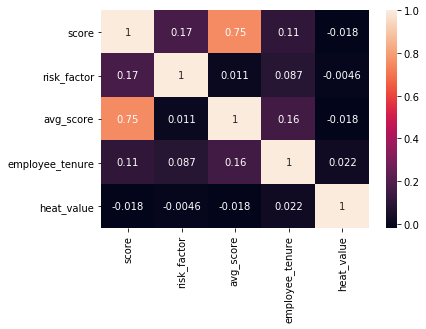

In [157]:
corrMatrix = daily_heat_model_data.corr()
sns.heatmap(corrMatrix, annot=True)

In [159]:
#checking for missing values
daily_heat_model_data.columns

Index(['score', 'risk_factor', 'classification', 'employee_tenure',
       'heat_value', 'function_group_Commercial', 'function_group_Enabling',
       'function_group_No_Data', 'function_group_Production', 'hru_HRU',
       ...
       'industry_focus_name_BUSINESS_SEGMENT_10',
       'industry_focus_name_BUSINESS_SEGMENT_11',
       'industry_focus_name_BUSINESS_SEGMENT_12',
       'industry_focus_name_BUSINESS_SEGMENT_13',
       'industry_focus_name_BUSINESS_SEGMENT_14',
       'industry_focus_name_BUSINESS_SEGMENT_4',
       'industry_focus_name_BUSINESS_SEGMENT_5',
       'industry_focus_name_BUSINESS_SEGMENT_6',
       'industry_focus_name_BUSINESS_SEGMENT_7',
       'industry_focus_name_BUSINESS_SEGMENT_8'],
      dtype='object', length=176)

In [296]:
#--------------------------------------------------
#--------------------------TP/HIGH------------------
#---------------------------------------------------
daily_heat_model_data['classification_Label'] = daily_heat_model_data['classification'].apply(lambda x: 1 if x =='TP/HIGH' else 0)
xdaily= daily_heat_model_data.drop(columns=['classification','classification_Label'])
ydaily= daily_heat_model_data.classification_Label
xdaily
from sklearn.model_selection import train_test_split
xtraindaily,xtestdaily,ytraindaily,ytestdaily = train_test_split(xdaily,ydaily,test_size=0.2)
xtraindaily.head(2)

weekly_heat_model_data['classification_Label'] = weekly_heat_model_data['classification'].apply(lambda x: 1 if x =='TP/HIGH' else 0)
xweekly= weekly_heat_model_data.drop(columns=['classification','classification_Label'])
yweekly= weekly_heat_model_data.classification_Label
xweekly
from sklearn.model_selection import train_test_split
xtrainweekly,xtestweekly,ytrainweekly,ytestweekly = train_test_split(xweekly,yweekly,test_size=0.2)
xtrainweekly.head(2)

monthly_heat_model_data['classification_Label'] = monthly_heat_model_data['classification'].apply(lambda x: 1 if x =='TP/HIGH' else 0)
xmonthly= monthly_heat_model_data.drop(columns=['classification','classification_Label'])
ymonthly= monthly_heat_model_data.classification_Label
xmonthly
from sklearn.model_selection import train_test_split
xtrainmonthly,xtestmonthly,ytrainmonthly,ytestmonthly = train_test_split(xmonthly,ymonthly,test_size=0.2)
xtrainmonthly.head(2)

score  risk_factor  employee_tenure  heat_value  \
43080   7404    71.192308              3.0         1.0   
66241   1618    14.981481             36.0        50.0   

       function_group_Commercial  function_group_Enabling  \
43080                          0                        0   
66241                          0                        0   

       function_group_No_Data  function_group_Production  hru_HRU  hru_HRU11  \
43080                       0                          1        0          0   
66241                       0                          1        0          0   

       ...  industry_focus_name_BUSINESS_SEGMENT_10  \
43080  ...                                        0   
66241  ...                                        0   

       industry_focus_name_BUSINESS_SEGMENT_11  \
43080                                        0   
66241                                        0   

       industry_focus_name_BUSINESS_SEGMENT_12  \
43080                                        0   
66241                                        0   

       industry_focus_name_BUSINESS_SEGMENT_13  \
43080                                        0   
66241                                        0   

       industry_focus_name_BUSINESS_SEGMENT_14  \
43080                                        0   
66241                                        0   

       industry_focus_name_BUSINESS_SEGMENT_4  \
43080                                       1   
66241                                       1   

       industry_focus_name_BUSINESS_SEGMENT_5  \
43080                                       0   
66241                                       0   

       industry_focus_name_BUSINESS_SEGMENT_6  \
43080                                       0   
66241                                       0   

       industry_focus_name_BUSINESS_SEGMENT_7  \
43080                                       0   
66241                                       0   

       industry_focus_name_BUSINESS_SEGMENT_8  
43080                                       0  
66241                                       0  

[2 rows x 175 columns]

In [297]:
yweekly.value_counts()

0    33357
1     1824
Name: classification_Label, dtype: int64

In [117]:
#--------------------------------------------
#------logistic model-----------------------
#---------------------------------------------
logregd = LogisticRegression(solver='sag')
logregd.fit(xtraindaily, ytraindaily)
y_predd = logregd.predict(xtestdaily)

logregw = LogisticRegression(solver='sag')
logregw.fit(xtrainweekly, ytrainweekly)
y_predw = logregw.predict(xtestweekly)

logregm = LogisticRegression(solver='sag')
logregm.fit(xtrainmonthly, ytrainmonthly)
y_predm = logregm.predict(xtestmonthly)


C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [121]:
#logistic model without oversampling the data
xtest= xtestdaily
ytest = ytestdaily
logreg =logregd
ypredtrain=logreg.predict(xtest)
pred = pd.DataFrame(data=ypredtrain)
pred
print('Accuarcy score ='+str(accuracy_score(ytest, pred)))
print('Random Forest Model Accuracy')
print(classification_report(ytest, pred))
cmtx = pd.DataFrame(confusion_matrix(ytest, pred,labels=[0,1]), 
    index=['true:0', 'true:1'], 
    columns=['pred:0', 'pred:1']
)
print(cmtx)

Accuarcy score =0.9643005973051813
Random Forest Model Accuracy
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      6942
           1       0.00      0.00      0.00       257

    accuracy                           0.96      7199
   macro avg       0.48      0.50      0.49      7199
weighted avg       0.93      0.96      0.95      7199

        pred:0  pred:1
true:0    6942       0
true:1     257       0


C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [119]:
#----------------------------------------------
#-------------decision tree-------------------
#---------------------------------------------------
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
xtrain=xtraindaily
ytrain = ytraindaily
# Train Decision Tree Classifer
dtmodel = dt.fit(xtrain, ytrain)

In [120]:
#logistic model without oversampling the data
xtest= xtestdaily
ytest = ytestdaily
ypredtrain=dtmodel.predict(xtest)
pred = pd.DataFrame(data=ypredtrain)
pred
print('Accuarcy score ='+str(accuracy_score(ytest, pred)))
print('Random Forest Model Accuracy')
print(classification_report(ytest, pred))
cmtx = pd.DataFrame(confusion_matrix(ytest, pred,labels=[0,1]), 
    index=['true:0', 'true:1'], 
    columns=['pred:0', 'pred:1']
)
print(cmtx)

Accuarcy score =0.9859702736491179
Random Forest Model Accuracy
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6942
           1       0.81      0.79      0.80       257

    accuracy                           0.99      7199
   macro avg       0.90      0.89      0.90      7199
weighted avg       0.99      0.99      0.99      7199

        pred:0  pred:1
true:0    6895      47
true:1      54     203


In [35]:
#Predict the response for test dataset
xtest= xtestdaily
ytest = ytestdaily
dt_y_pred = dtmodel.predict_proba(xtest)[:,1]
dt_y_pred = pd.DataFrame(data=dt_y_pred)
yact =ytest
threshold_list = [0.5,0.45,0.4,0.35,0.3,0.25,0.2,0.15,0.1,.05]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    Y_test_pred = dt_y_pred.applymap(lambda x: 1 if x>i else 0)
    print('Accuarcy score ='+str(accuracy_score(yact, Y_test_pred)))
    print('Random Forest Model Accuracy')
    print(classification_report(yact, Y_test_pred))
#     print(confusion_matrix(yact, Y_test_pred))
    cmtx = pd.DataFrame(confusion_matrix(yact, Y_test_pred,labels=[0,1]), 
    index=['true:0', 'true:1'], 
    columns=['pred:0', 'pred:1']
    )
    print(cmtx)


******** For i = 0.5 ******
Accuarcy score =0.9888873454646478
Random Forest Model Accuracy
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6938
           1       0.86      0.83      0.84       261

    accuracy                           0.99      7199
   macro avg       0.93      0.91      0.92      7199
weighted avg       0.99      0.99      0.99      7199

        pred:0  pred:1
true:0    6903      35
true:1      45     216

******** For i = 0.45 ******
Accuarcy score =0.9886095291012641
Random Forest Model Accuracy
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6938
           1       0.85      0.84      0.84       261

    accuracy                           0.99      7199
   macro avg       0.92      0.91      0.92      7199
weighted avg       0.99      0.99      0.99      7199

        pred:0  pred:1
true:0    6899      39
true:1      43     218

******** For i = 0.4

In [131]:
from sklearn.tree import export_graphviz
from IPython import display
# from sklearn.ensemble import RandomForestRegressor

import sklearn.tree as tree
import pydotplus
from sklearn.externals.six import StringIO 
from IPython.display import Image
import io
dot_data = StringIO()
tree.export_graphviz(dtmodel, 
 out_file=dot_data, 
 class_names= ['1','0'], # the target names.
 feature_names=xtrain.columns, # the feature names.
 filled=True, # Whether to fill in the boxes with colours.
 rounded=True, # Whether to round the corners of the boxes.
)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())



In [31]:
#----------------------------------------------
#-------------Random Forest-------------------
#---------------------------------------------------
xtest= xtestdaily
ytest = ytestdaily
xtrain= xtraindaily
ytrain = ytraindaily
rf = RandomForestClassifier(n_estimators=100)
# Train Random Forest Tree Classifer
rfmodel = rf.fit(xtrain, ytrain)

In [33]:
# #----------------------------------------------
# #-------------Random Forest-------------------
# #---------------------------------------------------
# rf = RandomForestClassifier()

# # Train Decision Tree Classifer
# rfmodel = rf.fit(smxtrain, smytrain)

#Predict the response for test dataset
rf_y_pred = rfmodel.predict_proba(xtest)[:,1]
rf_y_pred = pd.DataFrame(data=rf_y_pred)

yact =ytest
threshold_list = [0.5,0.45,0.4,0.35,0.3,0.25,0.2,0.15,0.1,.05,0.04,0.03,0.02,0.01]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    Y_test_pred = rf_y_pred.applymap(lambda x: 1 if x>i else 0)
    print('Accuarcy score ='+str(accuracy_score(yact, Y_test_pred)))
    print('Random Forest Model Accuracy')
    print(classification_report(yact, Y_test_pred))
#     print(confusion_matrix(yact, Y_test_pred))
    cmtx = pd.DataFrame(confusion_matrix(yact, Y_test_pred,labels=[0,1]), 
    index=['true:0', 'true:1'], 
    columns=['pred:0', 'pred:1']
    )
    print(cmtx)


******** For i = 0.5 ******
Accuarcy score =0.9847201000138908
Random Forest Model Accuracy
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6938
           1       0.85      0.70      0.77       261

    accuracy                           0.98      7199
   macro avg       0.92      0.85      0.88      7199
weighted avg       0.98      0.98      0.98      7199

        pred:0  pred:1
true:0    6907      31
true:1      79     182

******** For i = 0.45 ******
Accuarcy score =0.9852757327406584
Random Forest Model Accuracy
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6938
           1       0.85      0.72      0.78       261

    accuracy                           0.99      7199
   macro avg       0.92      0.86      0.89      7199
weighted avg       0.98      0.99      0.98      7199

        pred:0  pred:1
true:0    6904      34
true:1      72     189

******** For i = 0.4

In [276]:
#--------------------------------------------------------------------------------------------------
#------------------------------------SMOTE-------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------

# print('---------------------Daily---------------------------------')
# xtest= xtestdaily
# ytest = ytestdaily
# xtrain= xtraindaily
# ytrain = ytraindaily

# print('Before OverSampling, the shape of train_X: {}'.format(xtrain.shape)) 
# print('Before OverSampling, the shape of train_y: {} \n'.format(ytrain.shape)) 
# print("Before OverSampling, counts of label '1': {}".format(sum(ytrain == 1))) 
# print("Before OverSampling, counts of label '0': {} \n".format(sum(ytrain == 0))) 
# print("Before OverSampling, counts of label '1' in test: {}".format(sum(ytest == 1))) 
# print("Before OverSampling, counts of label '0' in test: {} \n".format(sum(ytest == 0))) 
# sm = SMOTE(random_state = 2) 
# smxtrain, smytrain = sm.fit_sample(xtrain, ytrain.ravel()) 
  
# print('After OverSampling, the shape of train_X: {}'.format(smxtrain.shape)) 
# print('After OverSampling, the shape of train_y: {} \n'.format(smytrain.shape)) 
  
# print("After OverSampling, counts of label '1': {}".format(sum(smytrain == 1))) 
# print("After OverSampling, counts of label '0': {}".format(sum(smytrain == 0))) 

# print('---------------------Weekely---------------------------------')
# xtest= xtestweekly
# ytest = ytestweekly
# xtrain= xtrainweekly
# ytrain = ytrainweekly

# print('Before OverSampling, the shape of train_X: {}'.format(xtrain.shape)) 
# print('Before OverSampling, the shape of train_y: {} \n'.format(ytrain.shape)) 
# print("Before OverSampling, counts of label '1': {}".format(sum(ytrain == 1))) 
# print("Before OverSampling, counts of label '0': {} \n".format(sum(ytrain == 0))) 
# print("Before OverSampling, counts of label '1' in test: {}".format(sum(ytest == 1))) 
# print("Before OverSampling, counts of label '0' in test: {} \n".format(sum(ytest == 0))) 
# sm = SMOTE(random_state = 2)
# smxtrain, smytrain = sm.fit_sample(xtrain, ytrain.ravel()) 
  
# print('After OverSampling, the shape of train_X: {}'.format(smxtrain.shape)) 
# print('After OverSampling, the shape of train_y: {} \n'.format(smytrain.shape)) 
  
# print("After OverSampling, counts of label '1': {}".format(sum(smytrain == 1))) 
# print("After OverSampling, counts of label '0': {}".format(sum(smytrain == 0))) 

print('---------------------Monthly---------------------------------')
xtest= xtestmonthly
ytest = ytestmonthly
xtrain= xtrainmonthly
ytrain = ytrainmonthly

print('Before OverSampling, the shape of train_X: {}'.format(xtrain.shape)) 
print('Before OverSampling, the shape of train_y: {} \n'.format(ytrain.shape)) 
print("Before OverSampling, counts of label '1': {}".format(sum(ytrain == 1))) 
print("Before OverSampling, counts of label '0': {} \n".format(sum(ytrain == 0))) 
print("Before OverSampling, counts of label '1' in test: {}".format(sum(ytest == 1))) 
print("Before OverSampling, counts of label '0' in test: {} \n".format(sum(ytest == 0))) 
sm = SMOTE(random_state = 2) 
smxtrain, smytrain = sm.fit_sample(xtrain, ytrain.ravel()) 
  
print('After OverSampling, the shape of train_X: {}'.format(smxtrain.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(smytrain.shape)) 
  
print("After OverSampling, counts of label '1': {}".format(sum(smytrain == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(smytrain == 0))) 

---------------------Monthly---------------------------------
Before OverSampling, the shape of train_X: (33932, 175)
Before OverSampling, the shape of train_y: (33932,) 

Before OverSampling, counts of label '1': 3314
Before OverSampling, counts of label '0': 30618 

Before OverSampling, counts of label '1' in test: 834
Before OverSampling, counts of label '0' in test: 7650 

After OverSampling, the shape of train_X: (61236, 175)
After OverSampling, the shape of train_y: (61236,) 

After OverSampling, counts of label '1': 30618
After OverSampling, counts of label '0': 30618


In [123]:
#--------------------------------------------
#------logistic model-----------------------
#---------------------------------------------
logreg = LogisticRegression(solver='sag')
logreg.fit(smxtrain, smytrain)



C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

In [124]:
#Predict the response for test dataset
logreg_y_pred = logreg.predict_proba(xtest)[:,1]
logreg_y_pred = pd.DataFrame(data=logreg_y_pred)

yact =ytest
threshold_list = [0.5,0.45,0.4,0.35,0.3,0.25,0.2,0.15,0.1,.05]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    Y_test_pred = logreg_y_pred.applymap(lambda x: 1 if x>i else 0)
    print('Accuarcy score ='+str(accuracy_score(yact, Y_test_pred)))
    print('Logstic Model Accuracy')
    print(classification_report(yact, Y_test_pred))
#     print(confusion_matrix(yact, Y_test_pred))
    cmtx = pd.DataFrame(confusion_matrix(yact, Y_test_pred,labels=[0,1]), 
    index=['true:0', 'true:1'], 
    columns=['pred:0', 'pred:1']
    )
    print(cmtx)

C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



******** For i = 0.5 ******
Accuarcy score =0.04372937293729373
Logstic Model Accuracy
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      8113
           1       0.04      1.00      0.08       371

    accuracy                           0.04      8484
   macro avg       0.02      0.50      0.04      8484
weighted avg       0.00      0.04      0.00      8484

        pred:0  pred:1
true:0       0    8113
true:1       0     371

******** For i = 0.45 ******
Accuarcy score =0.04372937293729373
Logstic Model Accuracy
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      8113
           1       0.04      1.00      0.08       371

    accuracy                           0.04      8484
   macro avg       0.02      0.50      0.04      8484
weighted avg       0.00      0.04      0.00      8484



C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


        pred:0  pred:1
true:0       0    8113
true:1       0     371

******** For i = 0.4 ******
Accuarcy score =0.04372937293729373
Logstic Model Accuracy
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      8113
           1       0.04      1.00      0.08       371

    accuracy                           0.04      8484
   macro avg       0.02      0.50      0.04      8484
weighted avg       0.00      0.04      0.00      8484

        pred:0  pred:1
true:0       0    8113
true:1       0     371

******** For i = 0.35 ******
Accuarcy score =0.04372937293729373
Logstic Model Accuracy
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      8113
           1       0.04      1.00      0.08       371

    accuracy                           0.04      8484
   macro avg       0.02      0.50      0.04      8484
weighted avg       0.00      0.04      0.00      8484



C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


        pred:0  pred:1
true:0       0    8113
true:1       0     371

******** For i = 0.3 ******
Accuarcy score =0.04372937293729373
Logstic Model Accuracy
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      8113
           1       0.04      1.00      0.08       371

    accuracy                           0.04      8484
   macro avg       0.02      0.50      0.04      8484
weighted avg       0.00      0.04      0.00      8484

        pred:0  pred:1
true:0       0    8113
true:1       0     371

******** For i = 0.25 ******
Accuarcy score =0.04372937293729373
Logstic Model Accuracy
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      8113
           1       0.04      1.00      0.08       371

    accuracy                           0.04      8484
   macro avg       0.02      0.50      0.04      8484
weighted avg       0.00      0.04      0.00      8484



C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


        pred:0  pred:1
true:0       0    8113
true:1       0     371

******** For i = 0.2 ******
Accuarcy score =0.04372937293729373
Logstic Model Accuracy
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      8113
           1       0.04      1.00      0.08       371

    accuracy                           0.04      8484
   macro avg       0.02      0.50      0.04      8484
weighted avg       0.00      0.04      0.00      8484

        pred:0  pred:1
true:0       0    8113
true:1       0     371

******** For i = 0.15 ******
Accuarcy score =0.04372937293729373
Logstic Model Accuracy
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      8113
           1       0.04      1.00      0.08       371

    accuracy                           0.04      8484
   macro avg       0.02      0.50      0.04      8484
weighted avg       0.00      0.04      0.00      8484


C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



        pred:0  pred:1
true:0       0    8113
true:1       0     371

******** For i = 0.1 ******
Accuarcy score =0.04372937293729373
Logstic Model Accuracy
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      8113
           1       0.04      1.00      0.08       371

    accuracy                           0.04      8484
   macro avg       0.02      0.50      0.04      8484
weighted avg       0.00      0.04      0.00      8484



C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


        pred:0  pred:1
true:0       0    8113
true:1       0     371

******** For i = 0.05 ******
Accuarcy score =0.04372937293729373
Logstic Model Accuracy
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      8113
           1       0.04      1.00      0.08       371

    accuracy                           0.04      8484
   macro avg       0.02      0.50      0.04      8484
weighted avg       0.00      0.04      0.00      8484

        pred:0  pred:1
true:0       0    8113
true:1       0     371


In [125]:
#----------------------------------------------
#-------------decision tree-------------------
#---------------------------------------------------
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()

# Train Decision Tree Classifer
dtmodel = dt.fit(smxtrain, smytrain)

In [126]:
#Predict the response for test dataset
dt_y_pred = dtmodel.predict_proba(xtest)[:,1]
dt_y_pred = pd.DataFrame(data=dt_y_pred)
yact =ytest
threshold_list = [0.5,0.45,0.4,0.35,0.3,0.25,0.2,0.15,0.1,.05]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    Y_test_pred = dt_y_pred.applymap(lambda x: 1 if x>i else 0)
    print('Accuarcy score ='+str(accuracy_score(yact, Y_test_pred)))
    print('Decision Tree Model Accuracy')
    print(classification_report(yact, Y_test_pred))
#     print(confusion_matrix(yact, Y_test_pred))
    cmtx = pd.DataFrame(confusion_matrix(yact, Y_test_pred,labels=[0,1]), 
    index=['true:0', 'true:1'], 
    columns=['pred:0', 'pred:1']
    )
    print(cmtx)


******** For i = 0.5 ******
Accuarcy score =0.9846770391324847
Decision Tree Model Accuracy
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8113
           1       0.83      0.82      0.82       371

    accuracy                           0.98      8484
   macro avg       0.91      0.91      0.91      8484
weighted avg       0.98      0.98      0.98      8484

        pred:0  pred:1
true:0    8049      64
true:1      66     305

******** For i = 0.45 ******
Accuarcy score =0.9847949080622348
Decision Tree Model Accuracy
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8113
           1       0.82      0.84      0.83       371

    accuracy                           0.98      8484
   macro avg       0.91      0.91      0.91      8484
weighted avg       0.98      0.98      0.98      8484

        pred:0  pred:1
true:0    8044      69
true:1      60     311

******** For i = 0.4

In [59]:
#---------Naive Baye's------
from sklearn.naive_bayes import MultinomialNB
mnb_model = MultinomialNB().fit(smxtrain, smytrain)

In [60]:
#Predict the response for test dataset
pred_mnb_val = mnb_model.predict_proba(xtest)[:,1]
pred_mnb_val = pd.DataFrame(data=pred_mnb_val)
yact =ytest

threshold_list = [0.5,0.45,0.4,0.35,0.3,0.25,0.2,0.15,0.1,.05]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    Y_test_pred = pred_mnb_val.applymap(lambda x: 1 if x>i else 0)
    print('Accuarcy score ='+str(accuracy_score(yact, Y_test_pred)))
    print('Multinimial Naive Bayes Model Accuracy')
    print(classification_report(yact, Y_test_pred))
#     print(confusion_matrix(yact, Y_test_pred))
    cmtx = pd.DataFrame(confusion_matrix(yact, Y_test_pred,labels=[0,1]), 
    index=['true:0', 'true:1'], 
    columns=['pred:0', 'pred:1']
    )
    print(cmtx)
    


******** For i = 0.5 ******
Accuarcy score =0.8726730140684951
Multinimial Naive Bayes Model Accuracy
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      6670
           1       0.16      0.33      0.21       367

    accuracy                           0.87      7037
   macro avg       0.56      0.61      0.57      7037
weighted avg       0.92      0.87      0.89      7037

        pred:0  pred:1
true:0    6021     649
true:1     247     120

******** For i = 0.45 ******
Accuarcy score =0.8728151200795794
Multinimial Naive Bayes Model Accuracy
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      6670
           1       0.16      0.33      0.21       367

    accuracy                           0.87      7037
   macro avg       0.56      0.62      0.57      7037
weighted avg       0.92      0.87      0.89      7037

        pred:0  pred:1
true:0    6021     649
true:1     246     121



In [304]:
#----------------------------------------------
#-------------Random Forest-------------------
#---------------------------------------------------
rf = RandomForestClassifier(n_estimators=100)
# Train Random Forest Tree Classifer
rfmodel = rf.fit(smxtrain, smytrain)

In [305]:
# #----------------------------------------------
# #-------------Random Forest-------------------
# #---------------------------------------------------

#Predict the response for test dataset
xtest=xweekly
ytest = yweekly
rf_y_pred = rfmodel.predict_proba(xtest)[:,1]
rf_y_pred = pd.DataFrame(data=rf_y_pred)

yact =ytest
threshold_list = [0.5,0.45,0.4,0.35,0.3,0.25,0.2,0.15,0.1,.08,.09,.07,.06,0.05,.04,.03,.02,.01]
for i in threshold_list:
    print ('\n******** For Probablity Threshold = {} ******'.format(i))
    Y_test_pred = rf_y_pred.applymap(lambda x: 1 if x>i else 0)
    print('Accuarcy score ='+str(accuracy_score(yact, Y_test_pred)))
    print('Random Forest Model Accuracy')
    print(classification_report(yact, Y_test_pred))
#     print(confusion_matrix(yact, Y_test_pred))
    cmtx = pd.DataFrame(confusion_matrix(yact, Y_test_pred,labels=[0,1]), 
    index=['true:0', 'true:1'], 
    columns=['pred:0', 'pred:1']
    )
    print(cmtx)


******** For Probablity Threshold = 0.5 ******
Accuarcy score =0.9981524118131946
Random Forest Model Accuracy
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     33357
           1       0.98      0.98      0.98      1824

    accuracy                           1.00     35181
   macro avg       0.99      0.99      0.99     35181
weighted avg       1.00      1.00      1.00     35181

        pred:0  pred:1
true:0   33324      33
true:1      32    1792

******** For Probablity Threshold = 0.45 ******
Accuarcy score =0.9981808362468377
Random Forest Model Accuracy
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     33357
           1       0.98      0.98      0.98      1824

    accuracy                           1.00     35181
   macro avg       0.99      0.99      0.99     35181
weighted avg       1.00      1.00      1.00     35181

        pred:0  pred:1
true:0   33322      35
true:1

        pred:0  pred:1
true:0   31819    1538
true:1       3    1821

******** For Probablity Threshold = 0.01 ******
Accuarcy score =0.9303032887069725
Random Forest Model Accuracy
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     33357
           1       0.43      1.00      0.60      1824

    accuracy                           0.93     35181
   macro avg       0.71      0.96      0.78     35181
weighted avg       0.97      0.93      0.94     35181

        pred:0  pred:1
true:0   30908    2449
true:1       3    1821


In [301]:

#--------------------------------------------------------------------------------------------------
#------------------------------------SMOTE-------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------

# print('---------------------Daily---------------------------------')
# xtest= xtestdaily
# ytest = ytestdaily
# xtrain= xtraindaily
# ytrain = ytraindaily

print('---------------------Weekely---------------------------------')
xtest= xtestweekly
ytest = ytestweekly
xtrain= xtrainweekly
ytrain = ytrainweekly



# print('---------------------Monthly---------------------------------')
# xtest= xtestmonthly
# ytest = ytestmonthly
# xtrain= xtrainmonthly
# ytrain = ytrainmonthly

print('Before OverSampling, the shape of train_X: {}'.format(xtrain.shape)) 
print('Before OverSampling, the shape of train_y: {} \n'.format(ytrain.shape)) 
print("Before OverSampling, counts of label '1': {}".format(sum(ytrain == 1))) 
print("Before OverSampling, counts of label '0': {} \n".format(sum(ytrain == 0))) 
print("Before OverSampling, counts of label '1' in test: {}".format(sum(ytest == 1))) 
print("Before OverSampling, counts of label '0' in test: {} \n".format(sum(ytest == 0))) 
sm = SMOTE(random_state = 2) 
smxtrain, smytrain = sm.fit_sample(xtrain, ytrain.ravel()) 
  
print('After OverSampling, the shape of train_X: {}'.format(smxtrain.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(smytrain.shape)) 
  
print("After OverSampling, counts of label '1': {}".format(sum(smytrain == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(smytrain == 0))) 

#-------------XGBoost-------------
# libaries for GBM
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=100)

# Train Random Forest Tree Classifer
xgbmodel = xgb.fit(smxtrain, smytrain)

---------------------Weekely---------------------------------
Before OverSampling, the shape of train_X: (28144, 175)
Before OverSampling, the shape of train_y: (28144,) 

Before OverSampling, counts of label '1': 1474
Before OverSampling, counts of label '0': 26670 

Before OverSampling, counts of label '1' in test: 350
Before OverSampling, counts of label '0' in test: 6687 

After OverSampling, the shape of train_X: (53340, 175)
After OverSampling, the shape of train_y: (53340,) 

After OverSampling, counts of label '1': 26670
After OverSampling, counts of label '0': 26670


In [306]:
yweekly.value_counts()

0    33357
1     1824
Name: classification_Label, dtype: int64

In [255]:
dfObj = pd.DataFrame()
dfObj['Threshold']=[.05]
dfObj['TP']=0
dfObj['FP']=0
dfObj['FN']=0

In [309]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
# writer = pd.ExcelWriter('pandas_multiple.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet.
dfObj.to_excel(writer, sheet_name='Monthly1_TP_HIGH_XGBOOST')

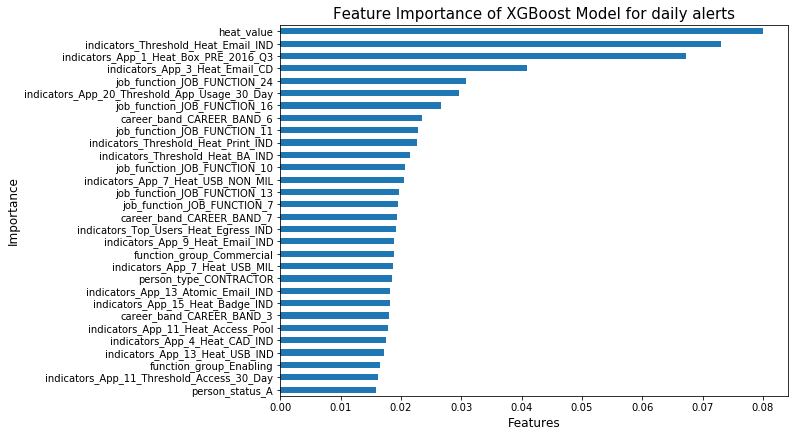

In [239]:
# Calculate feature importances

import pandas as pd
feature_importances = pd.DataFrame(xgbmodel.feature_importances_,
                                   index = smxtrain.columns,
                                    columns=['importance'])
feature_importances['Predictors'] = smxtrain.columns
feature_importances

plt.figure(figsize=(20, 15))
#fig,axarr = plt.subplots(2, 2, figsize=(18, 15))
#ax=sns.countplot(final_data[final_data['classification'] =='TP/HIGH']['Employee_tenure'], hue=final_data.classification)

feature_importances.sort_values('importance', inplace=True, ascending=False)
feature_importances.head(20)

plt.subplot(2,2,1)
feature_importances['importance'][0:30,].plot(kind='barh')
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.title('Feature Importance of XGBoost Model for daily alerts',fontsize=15)
plt.gca().invert_yaxis()

# sns.barplot(x="importance", y="Predictors", data=feature_importances[0:30])

In [240]:
from sklearn.tree import export_graphviz
from IPython import display
# display.display(str_tree)
estimator = rfmodel.estimators_[1]

import sklearn.tree as tree
import pydotplus
from sklearn.externals.six import StringIO 
from IPython.display import Image
import io
dot_data = StringIO()
tree.export_graphviz(estimator, 
 out_file=dot_data, 
 class_names= ['1','0'], # the target names.
 feature_names=smxtrain.columns, # the feature names.
 filled=True, # Whether to fill in the boxes with colours.
 rounded=True, # Whether to round the corners of the boxes.
)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())



dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.551188 to fit



Text(0.5, 1.0, 'Feature Importance of XGBoost Model for daily alerts')

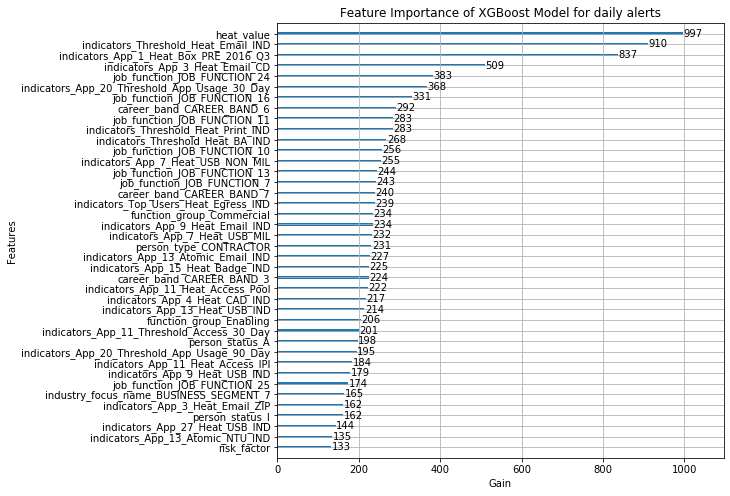

In [240]:

# plot feature importance using built-in function
from xgboost import plot_importance
from matplotlib import pyplot
plt.rcParams["figure.figsize"] = (8, 8)
# plot_importance(xgbmodel,importance_type='gain',max_num_features=20,xlabel ='Gain')
# plt.title('Top 20 Features of XGBoost Model',fontsize=12)
# pyplot.show()


# Get the booster from the xgbmodel
booster = xgbmodel.get_booster()

# Get the importance dictionary (by gain) from the booster
importance = xgbmodel.get_booster().get_score(importance_type="gain")

# make your changes
for key in importance.keys():
    importance[key] = round(importance[key])

# provide the importance dictionary to the plotting function
ax = plot_importance(importance, importance_type='gain', show_values=True,xlabel ='Gain',max_num_features=40)
plt.title('Feature Importance of XGBoost Model for daily alerts',fontsize=12)

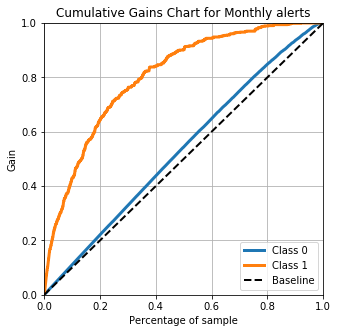

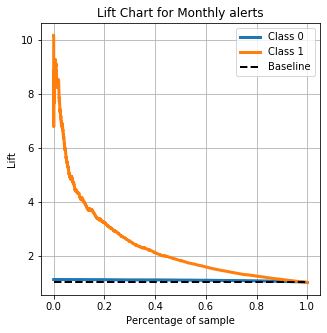

In [219]:
xgb_y_pred = xgbmodel.predict_proba(xtest)
# plotLiftChart(y, xgb_y_pred)
# xgb_y_pred = pd.DataFrame(data=xgb_y_pred)
import scikitplot as skplt

# plt.figure(figsize=(10, 10))
skplt.metrics.plot_cumulative_gain(ytest, xgb_y_pred,figsize=(5,5))

plt.title('Cumulative Gains Chart for Monthly alerts',fontsize=12)
plt.show()

skplt.metrics.plot_lift_curve(ytest, xgb_y_pred,figsize=(5,5))
plt.legend(loc='upper right')
plt.title('Lift Chart for Monthly alerts',fontsize=12)
plt.show()

In [320]:
#--------------------------------------------------
#--------------------------TP/HIGH +TP/LOW ------------------
#---------------------------------------------------
daily_heat_model_data['classification_Label'] = daily_heat_model_data['classification'].apply(lambda x: 1 if x =='TP/HIGH' or x == 'TP/LOW' else 0)
xdaily= daily_heat_model_data.drop(columns=['classification','classification_Label'])
ydaily= daily_heat_model_data.classification_Label
xdaily
from sklearn.model_selection import train_test_split
xtraindaily,xtestdaily,ytraindaily,ytestdaily = train_test_split(xdaily,ydaily,test_size=0.2)
xtraindaily.head(2)

weekly_heat_model_data['classification_Label'] = weekly_heat_model_data['classification'].apply(lambda x: 1 if x =='TP/HIGH' or x == 'TP/LOW' else 0)
xweekly= weekly_heat_model_data.drop(columns=['classification','classification_Label'])
yweekly= weekly_heat_model_data.classification_Label
xweekly
from sklearn.model_selection import train_test_split
xtrainweekly,xtestweekly,ytrainweekly,ytestweekly = train_test_split(xweekly,yweekly,test_size=0.2)
xtrainweekly.head(2)

monthly_heat_model_data['classification_Label'] = monthly_heat_model_data['classification'].apply(lambda x: 1 if x =='TP/HIGH' or x == 'TP/LOW' else 0)
xmonthly= monthly_heat_model_data.drop(columns=['classification','classification_Label'])
ymonthly= monthly_heat_model_data.classification_Label
xmonthly
from sklearn.model_selection import train_test_split
xtrainmonthly,xtestmonthly,ytrainmonthly,ytestmonthly = train_test_split(xmonthly,ymonthly,test_size=0.2)
xtrainmonthly.head(2)

score  risk_factor  employee_tenure  heat_value  \
74596    945    10.384615             12.0         3.0   
76628   1044     9.078261             42.0         3.0   

       function_group_Commercial  function_group_Enabling  \
74596                          0                        0   
76628                          0                        0   

       function_group_No_Data  function_group_Production  hru_HRU  hru_HRU11  \
74596                       0                          1        0          0   
76628                       0                          1        0          0   

       ...  industry_focus_name_BUSINESS_SEGMENT_10  \
74596  ...                                        0   
76628  ...                                        0   

       industry_focus_name_BUSINESS_SEGMENT_11  \
74596                                        0   
76628                                        0   

       industry_focus_name_BUSINESS_SEGMENT_12  \
74596                                        0   
76628                                        0   

       industry_focus_name_BUSINESS_SEGMENT_13  \
74596                                        0   
76628                                        0   

       industry_focus_name_BUSINESS_SEGMENT_14  \
74596                                        0   
76628                                        0   

       industry_focus_name_BUSINESS_SEGMENT_4  \
74596                                       1   
76628                                       1   

       industry_focus_name_BUSINESS_SEGMENT_5  \
74596                                       0   
76628                                       0   

       industry_focus_name_BUSINESS_SEGMENT_6  \
74596                                       0   
76628                                       0   

       industry_focus_name_BUSINESS_SEGMENT_7  \
74596                                       0   
76628                                       0   

       industry_focus_name_BUSINESS_SEGMENT_8  
74596                                       0  
76628                                       0  

[2 rows x 175 columns]

In [88]:
#--------------------------------------------
#------logistic model-----------------------
#---------------------------------------------
logregd = LogisticRegression(solver='sag')
logregd.fit(xtraindaily, ytraindaily)
y_predd = logregd.predict(xtestdaily)

# logregw = LogisticRegression(solver='sag')
# logregw.fit(xtrainweekly, ytrainweekly)
# y_predw = logregw.predict(xtestweekly)

# logregm = LogisticRegression(solver='sag')
# logregm.fit(xtrainmonthly, ytrainmonthly)
# y_predm = logregm.predict(xtestmonthly)

#Predict the response for test dataset
xtest = xtestdaily
ytest = ytestdaily
logreg_y_pred = logreg.predict_proba(xtest)[:,1]
logreg_y_pred = pd.DataFrame(data=logreg_y_pred)

yact =ytest
threshold_list = [0.5,0.45,0.4,0.35,0.3,0.25,0.2,0.15,0.1,.05]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    Y_test_pred = logreg_y_pred.applymap(lambda x: 1 if x>i else 0)
    print('Accuarcy score ='+str(accuracy_score(yact, Y_test_pred)))
    print('Logstic Model Accuracy')
    print(classification_report(yact, Y_test_pred))
#     print(confusion_matrix(yact, Y_test_pred))
    cmtx = pd.DataFrame(confusion_matrix(yact, Y_test_pred,labels=[0,1]), 
    index=['true:0', 'true:1'], 
    columns=['pred:0', 'pred:1']
    )
    print(cmtx)

C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



******** For i = 0.5 ******
Accuarcy score =0.08862341991943326
Logstic Model Accuracy
              precision    recall  f1-score   support

           0       0.90      0.01      0.02      6625
           1       0.08      0.99      0.15       574

    accuracy                           0.09      7199
   macro avg       0.49      0.50      0.08      7199
weighted avg       0.83      0.09      0.03      7199

        pred:0  pred:1
true:0      72    6553
true:1       8     566

******** For i = 0.45 ******
Accuarcy score =0.07973329629115154
Logstic Model Accuracy
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6625
           1       0.08      1.00      0.15       574

    accuracy                           0.08      7199
   macro avg       0.04      0.50      0.07      7199
weighted avg       0.01      0.08      0.01      7199

        pred:0  pred:1
true:0       0    6625
true:1       0     574

******** For i = 0.4 ******
Ac

C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


        pred:0  pred:1
true:0       0    6625
true:1       0     574

******** For i = 0.2 ******
Accuarcy score =0.07973329629115154
Logstic Model Accuracy
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6625
           1       0.08      1.00      0.15       574

    accuracy                           0.08      7199
   macro avg       0.04      0.50      0.07      7199
weighted avg       0.01      0.08      0.01      7199

        pred:0  pred:1
true:0       0    6625
true:1       0     574

******** For i = 0.15 ******
Accuarcy score =0.07973329629115154
Logstic Model Accuracy
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6625
           1       0.08      1.00      0.15       574

    accuracy                           0.08      7199
   macro avg       0.04      0.50      0.07      7199
weighted avg       0.01      0.08      0.01      7199

        pred:0  pred:1
true:0  

C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6625
           1       0.08      1.00      0.15       574

    accuracy                           0.08      7199
   macro avg       0.04      0.50      0.07      7199
weighted avg       0.01      0.08      0.01      7199

        pred:0  pred:1
true:0       0    6625
true:1       0     574

******** For i = 0.05 ******
Accuarcy score =0.07973329629115154
Logstic Model Accuracy
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6625
           1       0.08      1.00      0.15       574

    accuracy                           0.08      7199
   macro avg       0.04      0.50      0.07      7199
weighted avg       0.01      0.08      0.01      7199

        pred:0  pred:1
true:0       0    6625
true:1       0     574


C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [90]:
#----------------------------------------------
#-------------decision tree-------------------
#---------------------------------------------------
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()

# Train Decision Tree Classifer
dtmodel = dt.fit(xtraindaily, ytraindaily)

#Predict the response for test dataset
dt_y_pred = dtmodel.predict_proba(xtest)[:,1]
dt_y_pred = pd.DataFrame(data=dt_y_pred)
yact =ytest
threshold_list = [0.5,0.45,0.4,0.35,0.3,0.25,0.2,0.15,0.1,.05]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    Y_test_pred = dt_y_pred.applymap(lambda x: 1 if x>i else 0)
    print('Accuarcy score ='+str(accuracy_score(yact, Y_test_pred)))
    print('Decision Tree Model Accuracy')
    print(classification_report(yact, Y_test_pred))
#     print(confusion_matrix(yact, Y_test_pred))
    cmtx = pd.DataFrame(confusion_matrix(yact, Y_test_pred,labels=[0,1]), 
    index=['true:0', 'true:1'], 
    columns=['pred:0', 'pred:1']
    )
    print(cmtx)


******** For i = 0.5 ******
Accuarcy score =0.9684678427559383
Decision Tree Model Accuracy
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      6625
           1       0.80      0.80      0.80       574

    accuracy                           0.97      7199
   macro avg       0.89      0.89      0.89      7199
weighted avg       0.97      0.97      0.97      7199

        pred:0  pred:1
true:0    6514     111
true:1     116     458

******** For i = 0.45 ******
Accuarcy score =0.9668009445756355
Decision Tree Model Accuracy
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      6625
           1       0.77      0.83      0.80       574

    accuracy                           0.97      7199
   macro avg       0.88      0.91      0.89      7199
weighted avg       0.97      0.97      0.97      7199

        pred:0  pred:1
true:0    6481     144
true:1      95     479

******** For i = 0.4

In [287]:
#--------------------------------------------------------------------------------------------------
#------------------------------------SMOTE-------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------

# print('---------------------Daily---------------------------------')
# xtest= xtestdaily
# ytest = ytestdaily
# xtrain= xtraindaily
# ytrain = ytraindaily

# print('Before OverSampling, the shape of train_X: {}'.format(xtrain.shape)) 
# print('Before OverSampling, the shape of train_y: {} \n'.format(ytrain.shape)) 
# print("Before OverSampling, counts of label '1': {}".format(sum(ytrain == 1))) 
# print("Before OverSampling, counts of label '0': {} \n".format(sum(ytrain == 0))) 
# print("Before OverSampling, counts of label '1' in test: {}".format(sum(ytest == 1))) 
# print("Before OverSampling, counts of label '0' in test: {} \n".format(sum(ytest == 0))) 
# sm = SMOTE(random_state = 2) 
# smxtrain, smytrain = sm.fit_sample(xtrain, ytrain.ravel()) 
  
# print('After OverSampling, the shape of train_X: {}'.format(smxtrain.shape)) 
# print('After OverSampling, the shape of train_y: {} \n'.format(smytrain.shape)) 
  
# print("After OverSampling, counts of label '1': {}".format(sum(smytrain == 1))) 
# print("After OverSampling, counts of label '0': {}".format(sum(smytrain == 0))) 

# print('---------------------Weekely---------------------------------')
# xtest= xtestweekly
# ytest = ytestweekly
# xtrain= xtrainweekly
# ytrain = ytrainweekly

# print('Before OverSampling, the shape of train_X: {}'.format(xtrain.shape)) 
# print('Before OverSampling, the shape of train_y: {} \n'.format(ytrain.shape)) 
# print("Before OverSampling, counts of label '1': {}".format(sum(ytrain == 1))) 
# print("Before OverSampling, counts of label '0': {} \n".format(sum(ytrain == 0))) 
# print("Before OverSampling, counts of label '1' in test: {}".format(sum(ytest == 1))) 
# print("Before OverSampling, counts of label '0' in test: {} \n".format(sum(ytest == 0))) 
# sm = SMOTE(random_state = 2) 
# smxtrain, smytrain = sm.fit_sample(xtrain, ytrain.ravel()) 
  
# print('After OverSampling, the shape of train_X: {}'.format(smxtrain.shape)) 
# print('After OverSampling, the shape of train_y: {} \n'.format(smytrain.shape)) 
  
# print("After OverSampling, counts of label '1': {}".format(sum(smytrain == 1))) 
# print("After OverSampling, counts of label '0': {}".format(sum(smytrain == 0))) 

print('---------------------Monthly---------------------------------')
xtest= xtestmonthly
ytest = ytestmonthly
xtrain= xtrainmonthly
ytrain = ytrainmonthly

print('Before OverSampling, the shape of train_X: {}'.format(xtrain.shape)) 
print('Before OverSampling, the shape of train_y: {} \n'.format(ytrain.shape)) 
print("Before OverSampling, counts of label '1': {}".format(sum(ytrain == 1))) 
print("Before OverSampling, counts of label '0': {} \n".format(sum(ytrain == 0))) 
print("Before OverSampling, counts of label '1' in test: {}".format(sum(ytest == 1))) 
print("Before OverSampling, counts of label '0' in test: {} \n".format(sum(ytest == 0))) 
sm = SMOTE(random_state = 2) 
smxtrain, smytrain = sm.fit_sample(xtrain, ytrain.ravel()) 
  
print('After OverSampling, the shape of train_X: {}'.format(smxtrain.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(smytrain.shape)) 
  
print("After OverSampling, counts of label '1': {}".format(sum(smytrain == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(smytrain == 0))) 


---------------------Monthly---------------------------------
Before OverSampling, the shape of train_X: (33932, 175)
Before OverSampling, the shape of train_y: (33932,) 

Before OverSampling, counts of label '1': 3321
Before OverSampling, counts of label '0': 30611 

Before OverSampling, counts of label '1' in test: 827
Before OverSampling, counts of label '0' in test: 7657 

After OverSampling, the shape of train_X: (61222, 175)
After OverSampling, the shape of train_y: (61222,) 

After OverSampling, counts of label '1': 30611
After OverSampling, counts of label '0': 30611


In [110]:
#--------------------------------------------
#------logistic model-----------------------
#---------------------------------------------
logreg = LogisticRegression(solver='sag')
logreg.fit(smxtrain, smytrain)

#Predict the response for test dataset
logreg_y_pred = logreg.predict_proba(xtest)[:,1]
logreg_y_pred = pd.DataFrame(data=logreg_y_pred)

yact =ytest
threshold_list = [0.5,0.45,0.4,0.35,0.3,0.25,0.2,0.15,0.1,.05]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    Y_test_pred = logreg_y_pred.applymap(lambda x: 1 if x>i else 0)
    print('Accuarcy score ='+str(accuracy_score(yact, Y_test_pred)))
    print('Logstic Model Accuracy')
    print(classification_report(yact, Y_test_pred))
#     print(confusion_matrix(yact, Y_test_pred))
    cmtx = pd.DataFrame(confusion_matrix(yact, Y_test_pred,labels=[0,1]), 
    index=['true:0', 'true:1'], 
    columns=['pred:0', 'pred:1']
    )
    print(cmtx)

C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



******** For i = 0.5 ******
Accuarcy score =0.10278170674210278
Logstic Model Accuracy
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      7612
           1       0.10      1.00      0.19       872

    accuracy                           0.10      8484
   macro avg       0.05      0.50      0.09      8484
weighted avg       0.01      0.10      0.02      8484

        pred:0  pred:1
true:0       0    7612
true:1       0     872

******** For i = 0.45 ******
Accuarcy score =0.10278170674210278
Logstic Model Accuracy
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      7612
           1       0.10      1.00      0.19       872

    accuracy                           0.10      8484
   macro avg       0.05      0.50      0.09      8484
weighted avg       0.01      0.10      0.02      8484

        pred:0  pred:1
true:0       0    7612
true:1       0     872

******** For i = 0.4 ******
Ac

C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


        pred:0  pred:1
true:0       0    7612
true:1       0     872

******** For i = 0.35 ******
Accuarcy score =0.10278170674210278
Logstic Model Accuracy
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      7612
           1       0.10      1.00      0.19       872

    accuracy                           0.10      8484
   macro avg       0.05      0.50      0.09      8484
weighted avg       0.01      0.10      0.02      8484

        pred:0  pred:1
true:0       0    7612
true:1       0     872

******** For i = 0.3 ******
Accuarcy score =0.10278170674210278
Logstic Model Accuracy
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      7612
           1       0.10      1.00      0.19       872

    accuracy                           0.10      8484
   macro avg       0.05      0.50      0.09      8484
weighted avg       0.01      0.10      0.02      8484

        pred:0  pred:1
true:0  

C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuarcy score =0.10278170674210278
Logstic Model Accuracy
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      7612
           1       0.10      1.00      0.19       872

    accuracy                           0.10      8484
   macro avg       0.05      0.50      0.09      8484
weighted avg       0.01      0.10      0.02      8484

        pred:0  pred:1
true:0       0    7612
true:1       0     872

******** For i = 0.2 ******
Accuarcy score =0.10278170674210278
Logstic Model Accuracy
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      7612
           1       0.10      1.00      0.19       872

    accuracy                           0.10      8484
   macro avg       0.05      0.50      0.09      8484
weighted avg       0.01      0.10      0.02      8484

        pred:0  pred:1
true:0       0    7612
true:1       0     872

******** For i = 0.15 ******
Accuarcy score =0.1027817067421

C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


        pred:0  pred:1
true:0       0    7612
true:1       0     872


In [111]:
#----------------------------------------------
#-------------decision tree-------------------
#---------------------------------------------------
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()

# Train Decision Tree Classifer
dtmodel = dt.fit(smxtrain, smytrain)

#Predict the response for test dataset
dt_y_pred = dtmodel.predict_proba(xtest)[:,1]
dt_y_pred = pd.DataFrame(data=dt_y_pred)
yact =ytest
threshold_list = [0.5,0.45,0.4,0.35,0.3,0.25,0.2,0.15,0.1,.05]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    Y_test_pred = dt_y_pred.applymap(lambda x: 1 if x>i else 0)
    print('Accuarcy score ='+str(accuracy_score(yact, Y_test_pred)))
    print('Decision Tree Model Accuracy')
    print(classification_report(yact, Y_test_pred))
#     print(confusion_matrix(yact, Y_test_pred))
    cmtx = pd.DataFrame(confusion_matrix(yact, Y_test_pred,labels=[0,1]), 
    index=['true:0', 'true:1'], 
    columns=['pred:0', 'pred:1']
    )
    print(cmtx)


******** For i = 0.5 ******
Accuarcy score =0.964992927864215
Decision Tree Model Accuracy
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      7612
           1       0.83      0.84      0.83       872

    accuracy                           0.96      8484
   macro avg       0.90      0.91      0.91      8484
weighted avg       0.97      0.96      0.97      8484

        pred:0  pred:1
true:0    7458     154
true:1     143     729

******** For i = 0.45 ******
Accuarcy score =0.9645214521452146
Decision Tree Model Accuracy
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      7612
           1       0.82      0.84      0.83       872

    accuracy                           0.96      8484
   macro avg       0.90      0.91      0.90      8484
weighted avg       0.96      0.96      0.96      8484

        pred:0  pred:1
true:0    7450     162
true:1     139     733

******** For i = 0.4 

In [351]:
yweekly.value_counts()

0    31071
1     4110
Name: classification_Label, dtype: int64

In [344]:
# #----------------------------------------------
# #-------------Random Forest-------------------
# #---------------------------------------------------
#----------------------------------------------
#-------------Random Forest-------------------
#---------------------------------------------------
rf = RandomForestClassifier(n_estimators=100)
# Train Random Forest Tree Classifer
rfmodel = rf.fit(smxtrain, smytrain)

#Predict the response for test dataset
xtest = xweekly
ytest = yweekly
rf_y_pred = rfmodel.predict_proba(xtest)[:,1]
rf_y_pred = pd.DataFrame(data=rf_y_pred)

yact =ytest
threshold_list = [0.5,0.45,0.4,0.35,0.3,0.25,0.2,0.15,0.1,.09,.08,.07,.06,.05,.04,.03,.02,.01,.005,.001]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    Y_test_pred = rf_y_pred.applymap(lambda x: 1 if x>i else 0)
    print('Accuarcy score ='+str(accuracy_score(yact, Y_test_pred)))
    print('Random Forest Model Accuracy')
    print(classification_report(yact, Y_test_pred))
#     print(confusion_matrix(yact, Y_test_pred))
    cmtx = pd.DataFrame(confusion_matrix(yact, Y_test_pred,labels=[0,1]), 
    index=['true:0', 'true:1'], 
    columns=['pred:0', 'pred:1']
    )
    print(cmtx)


******** For i = 0.5 ******
Accuarcy score =0.9949972996788039
Random Forest Model Accuracy
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     31071
           1       0.98      0.98      0.98      4110

    accuracy                           0.99     35181
   macro avg       0.99      0.99      0.99     35181
weighted avg       0.99      0.99      0.99     35181

        pred:0  pred:1
true:0   30994      77
true:1      99    4011

******** For i = 0.45 ******
Accuarcy score =0.9949972996788039
Random Forest Model Accuracy
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     31071
           1       0.98      0.98      0.98      4110

    accuracy                           0.99     35181
   macro avg       0.99      0.99      0.99     35181
weighted avg       1.00      0.99      0.99     35181

        pred:0  pred:1
true:0   30980      91
true:1      85    4025

******** For i = 0.4

        pred:0  pred:1
true:0   27568    3503
true:1       5    4105

******** For i = 0.01 ******
Accuarcy score =0.8565987322702595
Random Forest Model Accuracy
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     31071
           1       0.45      1.00      0.62      4110

    accuracy                           0.86     35181
   macro avg       0.72      0.92      0.77     35181
weighted avg       0.94      0.86      0.88     35181

        pred:0  pred:1
true:0   26030    5041
true:1       4    4106


In [346]:
threshold_list = [.01,.005,.001,.009]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    Y_test_pred = rf_y_pred.applymap(lambda x: 1 if x>i else 0)
    print('Accuarcy score ='+str(accuracy_score(yact, Y_test_pred)))
    print('Random Forest Model Accuracy')
    print(classification_report(yact, Y_test_pred))
#     print(confusion_matrix(yact, Y_test_pred))
    cmtx = pd.DataFrame(confusion_matrix(yact, Y_test_pred,labels=[0,1]), 
    index=['true:0', 'true:1'], 
    columns=['pred:0', 'pred:1']
    )
    print(cmtx)


******** For i = 0.01 ******
Accuarcy score =0.8565987322702595
Random Forest Model Accuracy
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     31071
           1       0.45      1.00      0.62      4110

    accuracy                           0.86     35181
   macro avg       0.72      0.92      0.77     35181
weighted avg       0.94      0.86      0.88     35181

        pred:0  pred:1
true:0   26030    5041
true:1       4    4106

******** For i = 0.005 ******
Accuarcy score =0.7528779739063699
Random Forest Model Accuracy
              precision    recall  f1-score   support

           0       1.00      0.72      0.84     31071
           1       0.32      1.00      0.49      4110

    accuracy                           0.75     35181
   macro avg       0.66      0.86      0.66     35181
weighted avg       0.92      0.75      0.80     35181

        pred:0  pred:1
true:0   22381    8690
true:1       4    4106

******** For i = 0

In [338]:
ydaily.value_counts()

0    33053
1     2942
Name: classification_Label, dtype: int64

In [295]:
	#-------------XGBoost-------------
# libaries for GBM
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=100)

# Train Random Forest Tree Classifer
xgbmodel = xgb.fit(smxtrain, smytrain)

#-------------XGBoost-------------
#Predict the response for test dataset
xtest =x
ytest =y
xgb_y_pred = xgbmodel.predict_proba(xtest)[:,1]
xgb_y_pred = pd.DataFrame(data=xgb_y_pred)

yact =ytest
threshold_list = [0.5,0.45,0.4,0.35,0.3,0.25,0.2,0.15,0.1,.09,.08,.07,.06,.05,.04,.03,.02,.01]
k=-1
for i in threshold_list:
    print ('\n******** For Threshold = {} ******'.format(i))
    Y_test_pred = xgb_y_pred.applymap(lambda x: 1 if x>i else 0)
    print('Accuarcy score ='+str(accuracy_score(yact, Y_test_pred)))
    print('Gradient Boost Model Accuracy')
    print(classification_report(yact, Y_test_pred))
#     print(confusion_matrix(yact, Y_test_pred))
    cmtx = pd.DataFrame(confusion_matrix(yact, Y_test_pred,labels=[0,1]), 
    index=['true:0', 'true:1'], 
    columns=['pred:0','pred:1']
    )
    print(cmtx)
    k=k+1
    dfObj.loc[k]=[0,0,0,0]
    dfObj.iloc[k,0]=i
    dfObj.iloc[k,1]=cmtx.iloc[1,1]
    dfObj.iloc[k,2]=cmtx.iloc[0,1]
    dfObj.iloc[k,3]=cmtx.iloc[1,0]

# Write each dataframe to a different worksheet.
dfObj.to_excel(writer, sheet_name='Daily_TP_HIGH_LOW_XGBOOST')

---------------------Weekely---------------------------------
Before OverSampling, the shape of train_X: (28144, 175)
Before OverSampling, the shape of train_y: (28144,) 

Before OverSampling, counts of label '1': 3283
Before OverSampling, counts of label '0': 24861 

Before OverSampling, counts of label '1' in test: 827
Before OverSampling, counts of label '0' in test: 6210 

After OverSampling, the shape of train_X: (49722, 175)
After OverSampling, the shape of train_y: (49722,) 

After OverSampling, counts of label '1': 24861
After OverSampling, counts of label '0': 24861

******** For Threshold = 0.5 ******
Accuarcy score =0.8867854807992951
Gradient Boost Model Accuracy
              precision    recall  f1-score   support

           0       0.97      0.90      0.93     31071
           1       0.51      0.78      0.62      4110

    accuracy                           0.89     35181
   macro avg       0.74      0.84      0.78     35181
weighted avg       0.92      0.89      0.90 

        pred:0  pred:1
true:0      61   31010
true:1       0    4110

******** For Threshold = 0.02 ******
Accuarcy score =0.11747818424717887
Gradient Boost Model Accuracy
              precision    recall  f1-score   support

           0       1.00      0.00      0.00     31071
           1       0.12      1.00      0.21      4110

    accuracy                           0.12     35181
   macro avg       0.56      0.50      0.11     35181
weighted avg       0.90      0.12      0.03     35181

        pred:0  pred:1
true:0      23   31048
true:1       0    4110

******** For Threshold = 0.01 ******
Accuarcy score =0.1168244222733862
Gradient Boost Model Accuracy
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     31071
           1       0.12      1.00      0.21      4110

    accuracy                           0.12     35181
   macro avg       0.06      0.50      0.10     35181
weighted avg       0.01      0.12      0.02     35181



C:\Users\shwet\Anaconda3\envs\py36\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


        pred:0  pred:1
true:0       0   31071
true:1       0    4110


In [339]:
# print('---------------------Daily---------------------------------')
xtest= xtestdaily
ytest = ytestdaily
xtrain= xtraindaily
ytrain = ytraindaily

print('Before OverSampling, the shape of train_X: {}'.format(xtrain.shape)) 
print('Before OverSampling, the shape of train_y: {} \n'.format(ytrain.shape)) 
print("Before OverSampling, counts of label '1': {}".format(sum(ytrain == 1))) 
print("Before OverSampling, counts of label '0': {} \n".format(sum(ytrain == 0))) 
print("Before OverSampling, counts of label '1' in test: {}".format(sum(ytest == 1))) 
print("Before OverSampling, counts of label '0' in test: {} \n".format(sum(ytest == 0))) 
sm = SMOTE(random_state = 2) 
smxtrain, smytrain = sm.fit_sample(xtrain, ytrain.ravel()) 
  
print('After OverSampling, the shape of train_X: {}'.format(smxtrain.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(smytrain.shape)) 
  
print("After OverSampling, counts of label '1': {}".format(sum(smytrain == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(smytrain == 0))) 

from xgboost import XGBClassifier
rf = RandomForestClassifier(n_estimators=100)

# Train Random Forest Tree Classifer
xgbmodel = rf.fit(smxtrain, smytrain)

#-------------XGBoost-------------
#Predict the response for test dataset
xtest = xdaily
ytest = ydaily
xgb_y_pred = xgbmodel.predict_proba(xtest)[:,1]
xgb_y_pred = pd.DataFrame(data=xgb_y_pred)

yact =ytest
threshold_list = [0.5,0.45,0.4,0.35,0.3,0.25,0.2,0.15,0.1,.09,.08,.07,.06,.05,.04,.03,.02,.01]
k=-1
for i in threshold_list:
    print ('\n******** For Threshold = {} ******'.format(i))
    Y_test_pred = xgb_y_pred.applymap(lambda x: 1 if x>i else 0)
    print('Accuarcy score ='+str(accuracy_score(yact, Y_test_pred)))
    print('Gradient Boost Model Accuracy')
    print(classification_report(yact, Y_test_pred))
#     print(confusion_matrix(yact, Y_test_pred))
    cmtx = pd.DataFrame(confusion_matrix(yact, Y_test_pred,labels=[0,1]), 
    index=['true:0', 'true:1'], 
    columns=['pred:0','pred:1']
    )
    print(cmtx)
    k=k+1
    dfObj.loc[k]=[0,0,0,0]
    dfObj.iloc[k,0]=i
    dfObj.iloc[k,1]=cmtx.iloc[1,1]
    dfObj.iloc[k,2]=cmtx.iloc[0,1]
    dfObj.iloc[k,3]=cmtx.iloc[1,0]

# Write each dataframe to a different worksheet.
writer = pd.ExcelWriter('pandas_multiple.xlsx', engine='xlsxwriter')
dfObj.to_excel(writer, sheet_name='Daily_TP_HIGH_LOW_RF')


Before OverSampling, the shape of train_X: (28796, 175)
Before OverSampling, the shape of train_y: (28796,) 

Before OverSampling, counts of label '1': 2348
Before OverSampling, counts of label '0': 26448 

Before OverSampling, counts of label '1' in test: 594
Before OverSampling, counts of label '0' in test: 6605 

After OverSampling, the shape of train_X: (52896, 175)
After OverSampling, the shape of train_y: (52896,) 

After OverSampling, counts of label '1': 26448
After OverSampling, counts of label '0': 26448

******** For Threshold = 0.5 ******
Accuarcy score =0.9870815391026532
Gradient Boost Model Accuracy
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     33053
           1       0.92      0.92      0.92      2942

    accuracy                           0.99     35995
   macro avg       0.96      0.96      0.96     35995
weighted avg       0.99      0.99      0.99     35995

        pred:0  pred:1
true:0   32819     234
true:

        pred:0  pred:1
true:0   28933    4120
true:1      30    2912

******** For Threshold = 0.02 ******
Accuarcy score =0.858869287401028
Gradient Boost Model Accuracy
              precision    recall  f1-score   support

           0       1.00      0.85      0.92     33053
           1       0.37      0.99      0.53      2942

    accuracy                           0.86     35995
   macro avg       0.68      0.92      0.73     35995
weighted avg       0.95      0.86      0.89     35995

        pred:0  pred:1
true:0   27998    5055
true:1      25    2917

******** For Threshold = 0.01 ******
Accuarcy score =0.8105014585359077
Gradient Boost Model Accuracy
              precision    recall  f1-score   support

           0       1.00      0.79      0.89     33053
           1       0.30      0.99      0.46      2942

    accuracy                           0.81     35995
   macro avg       0.65      0.89      0.67     35995
weighted avg       0.94      0.81      0.85     35995

   

In [343]:

print('---------------------Weekely---------------------------------')
xtest= xtestweekly
ytest = ytestweekly
xtrain= xtrainweekly
ytrain = ytrainweekly

print('Before OverSampling, the shape of train_X: {}'.format(xtrain.shape)) 
print('Before OverSampling, the shape of train_y: {} \n'.format(ytrain.shape)) 
print("Before OverSampling, counts of label '1': {}".format(sum(ytrain == 1))) 
print("Before OverSampling, counts of label '0': {} \n".format(sum(ytrain == 0))) 
print("Before OverSampling, counts of label '1' in test: {}".format(sum(ytest == 1))) 
print("Before OverSampling, counts of label '0' in test: {} \n".format(sum(ytest == 0))) 
sm = SMOTE(random_state = 2) 
smxtrain, smytrain = sm.fit_sample(xtrain, ytrain.ravel()) 
  
print('After OverSampling, the shape of train_X: {}'.format(smxtrain.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(smytrain.shape)) 
  
print("After OverSampling, counts of label '1': {}".format(sum(smytrain == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(smytrain == 0))) 

from xgboost import XGBClassifier
rf = RandomForestClassifier(n_estimators=100)
# Train Random Forest Tree Classifer
xgbmodel = rf.fit(smxtrain, smytrain)

#-------------XGBoost-------------
#Predict the response for test dataset
xtest =xweekly
ytest =yweekly
xgb_y_pred = xgbmodel.predict_proba(xtest)[:,1]
xgb_y_pred = pd.DataFrame(data=xgb_y_pred)

yact =ytest
threshold_list = [0.5,0.45,0.4,0.35,0.3,0.25,0.2,0.15,0.1,.09,.08,.07,.06,.05,.04,.03,.02,.01]
k=-1
for i in threshold_list:
    print ('\n******** For Threshold = {} ******'.format(i))
    Y_test_pred = xgb_y_pred.applymap(lambda x: 1 if x>i else 0)
    print('Accuarcy score ='+str(accuracy_score(yact, Y_test_pred)))
    print('Gradient Boost Model Accuracy')
    print(classification_report(yact, Y_test_pred))
#     print(confusion_matrix(yact, Y_test_pred))
    cmtx = pd.DataFrame(confusion_matrix(yact, Y_test_pred,labels=[0,1]), 
    index=['true:0', 'true:1'], 
    columns=['pred:0','pred:1']
    )
    print(cmtx)
#     k=k+1
#     dfObj.loc[k]=[0,0,0,0]
#     dfObj.iloc[k,0]=i
#     dfObj.iloc[k,1]=cmtx.iloc[1,1]
#     dfObj.iloc[k,2]=cmtx.iloc[0,1]
#     dfObj.iloc[k,3]=cmtx.iloc[1,0]

# writer = pd.ExcelWriter('pandas_multiple.xlsx', engine='xlsxwriter')
# Write each dataframe to a different worksheet.
dfObj.to_excel(writer, sheet_name='Weekly_TP_HIGH_LOW_RF')


---------------------Weekely---------------------------------
Before OverSampling, the shape of train_X: (28144, 175)
Before OverSampling, the shape of train_y: (28144,) 

Before OverSampling, counts of label '1': 3287
Before OverSampling, counts of label '0': 24857 

Before OverSampling, counts of label '1' in test: 823
Before OverSampling, counts of label '0' in test: 6214 

After OverSampling, the shape of train_X: (49714, 175)
After OverSampling, the shape of train_y: (49714,) 

After OverSampling, counts of label '1': 24857
After OverSampling, counts of label '0': 24857

******** For Threshold = 0.5 ******
Accuarcy score =0.995025724112447
Gradient Boost Model Accuracy
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     31071
           1       0.98      0.98      0.98      4110

    accuracy                           1.00     35181
   macro avg       0.99      0.99      0.99     35181
weighted avg       1.00      1.00      1.00  

        pred:0  pred:1
true:0   28410    2661
true:1       6    4104

******** For Threshold = 0.02 ******
Accuarcy score =0.9002586623461527
Gradient Boost Model Accuracy
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     31071
           1       0.54      1.00      0.70      4110

    accuracy                           0.90     35181
   macro avg       0.77      0.94      0.82     35181
weighted avg       0.95      0.90      0.91     35181

        pred:0  pred:1
true:0   27567    3504
true:1       5    4105

******** For Threshold = 0.01 ******
Accuarcy score =0.8588442625280691
Gradient Boost Model Accuracy
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     31071
           1       0.45      1.00      0.62      4110

    accuracy                           0.86     35181
   macro avg       0.73      0.92      0.77     35181
weighted avg       0.94      0.86      0.88     35181

  

In [341]:

print('---------------------Monthly---------------------------------')
xtest= xtestmonthly
ytest = ytestmonthly
xtrain= xtrainmonthly
ytrain = ytrainmonthly

print('Before OverSampling, the shape of train_X: {}'.format(xtrain.shape)) 
print('Before OverSampling, the shape of train_y: {} \n'.format(ytrain.shape)) 
print("Before OverSampling, counts of label '1': {}".format(sum(ytrain == 1))) 
print("Before OverSampling, counts of label '0': {} \n".format(sum(ytrain == 0))) 
print("Before OverSampling, counts of label '1' in test: {}".format(sum(ytest == 1))) 
print("Before OverSampling, counts of label '0' in test: {} \n".format(sum(ytest == 0))) 
sm = SMOTE(random_state = 2) 
smxtrain, smytrain = sm.fit_sample(xtrain, ytrain.ravel()) 
  
print('After OverSampling, the shape of train_X: {}'.format(smxtrain.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(smytrain.shape)) 
  
print("After OverSampling, counts of label '1': {}".format(sum(smytrain == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(smytrain == 0))) 

from xgboost import XGBClassifier
rf = RandomForestClassifier(n_estimators=100)

# Train Random Forest Tree Classifer
xgbmodel = rf.fit(smxtrain, smytrain)

#-------------XGBoost-------------
#Predict the response for test dataset
xtest =xmonthly
ytest =ymonthly
xgb_y_pred = xgbmodel.predict_proba(xtest)[:,1]
xgb_y_pred = pd.DataFrame(data=xgb_y_pred)

yact =ytest
threshold_list = [0.5,0.45,0.4,0.35,0.3,0.25,0.2,0.15,0.1,.09,.08,.07,.06,.05,.04,.03,.02,.01]
k=-1
for i in threshold_list:
    print ('\n******** For Threshold = {} ******'.format(i))
    Y_test_pred = xgb_y_pred.applymap(lambda x: 1 if x>i else 0)
    print('Accuarcy score ='+str(accuracy_score(yact, Y_test_pred)))
    print('Gradient Boost Model Accuracy')
    print(classification_report(yact, Y_test_pred))
#     print(confusion_matrix(yact, Y_test_pred))
    cmtx = pd.DataFrame(confusion_matrix(yact, Y_test_pred,labels=[0,1]), 
    index=['true:0', 'true:1'], 
    columns=['pred:0','pred:1']
    )
    print(cmtx)
    k=k+1
    dfObj.loc[k]=[0,0,0,0]
    dfObj.iloc[k,0]=i
    dfObj.iloc[k,1]=cmtx.iloc[1,1]
    dfObj.iloc[k,2]=cmtx.iloc[0,1]
    dfObj.iloc[k,3]=cmtx.iloc[1,0]

# writer = pd.ExcelWriter('pandas_multiple.xlsx', engine='xlsxwriter')
# Write each dataframe to a different worksheet.
dfObj.to_excel(writer, sheet_name='Monthly_TP_HIGH_LOW_RF')


---------------------Monthly---------------------------------
Before OverSampling, the shape of train_X: (33932, 175)
Before OverSampling, the shape of train_y: (33932,) 

Before OverSampling, counts of label '1': 3305
Before OverSampling, counts of label '0': 30627 

Before OverSampling, counts of label '1' in test: 843
Before OverSampling, counts of label '0' in test: 7641 

After OverSampling, the shape of train_X: (61254, 175)
After OverSampling, the shape of train_y: (61254,) 

After OverSampling, counts of label '1': 30627
After OverSampling, counts of label '0': 30627

******** For Threshold = 0.5 ******
Accuarcy score =0.9926207091663524
Gradient Boost Model Accuracy
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     38268
           1       0.96      0.96      0.96      4148

    accuracy                           0.99     42416
   macro avg       0.98      0.98      0.98     42416
weighted avg       0.99      0.99      0.99 

        pred:0  pred:1
true:0   34542    3726
true:1      20    4128

******** For Threshold = 0.02 ******
Accuarcy score =0.8863400603545831
Gradient Boost Model Accuracy
              precision    recall  f1-score   support

           0       1.00      0.87      0.93     38268
           1       0.46      1.00      0.63      4148

    accuracy                           0.89     42416
   macro avg       0.73      0.94      0.78     42416
weighted avg       0.95      0.89      0.90     42416

        pred:0  pred:1
true:0   33465    4803
true:1      18    4130

******** For Threshold = 0.01 ******
Accuarcy score =0.8400132025650698
Gradient Boost Model Accuracy
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     38268
           1       0.38      1.00      0.55      4148

    accuracy                           0.84     42416
   macro avg       0.69      0.91      0.73     42416
weighted avg       0.94      0.84      0.87     42416

  

In [342]:

writer.save()

Text(0.5, 1.0, 'Feature Importance of XGBoost Model for Weekly alerts')

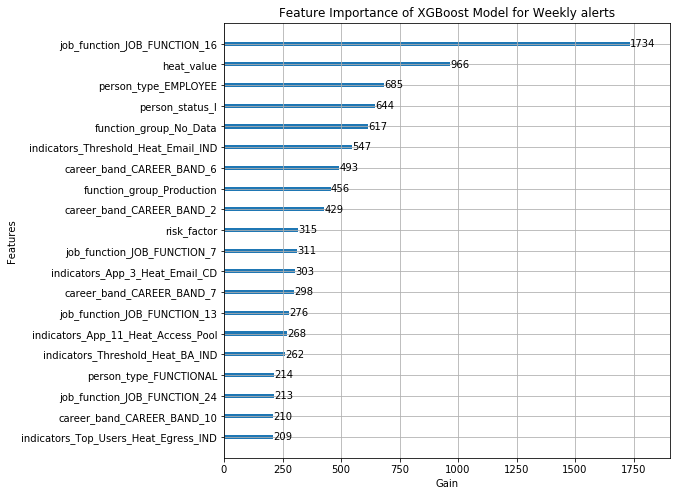

In [200]:

# plot feature importance using built-in function
from xgboost import plot_importance
from matplotlib import pyplot
plt.rcParams["figure.figsize"] = (8, 8)
# plot_importance(xgbmodel,importance_type='gain',max_num_features=20,xlabel ='Gain')
# plt.title('Top 20 Features of XGBoost Model',fontsize=12)
# pyplot.show()


# Get the booster from the xgbmodel
booster = xgbmodel.get_booster()

# Get the importance dictionary (by gain) from the booster
importance = xgbmodel.get_booster().get_score(importance_type="gain")

# make your changes
for key in importance.keys():
    importance[key] = round(importance[key])

# provide the importance dictionary to the plotting function
ax = plot_importance(importance, importance_type='gain', show_values=True,xlabel ='Gain',max_num_features=20)
plt.title('Feature Importance of XGBoost Model for Weekly alerts',fontsize=12)

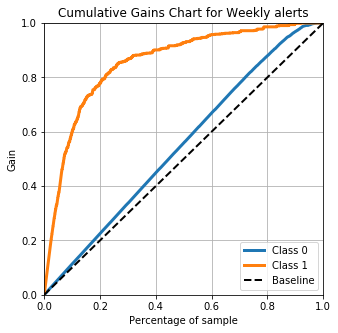

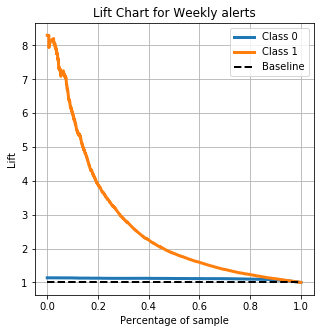

In [201]:
xgb_y_pred = xgbmodel.predict_proba(xtest)
# plotLiftChart(y, xgb_y_pred)
# xgb_y_pred = pd.DataFrame(data=xgb_y_pred)
import scikitplot as skplt

# plt.figure(figsize=(10, 10))
skplt.metrics.plot_cumulative_gain(ytest, xgb_y_pred,figsize=(5,5))
plt.title('Cumulative Gains Chart for Weekly alerts',fontsize=12)
plt.show()

skplt.metrics.plot_lift_curve(ytest, xgb_y_pred,figsize=(5,5))
plt.legend(loc='upper right')
plt.title('Lift Chart for Weekly alerts',fontsize=12)
plt.show()